# Model Prediction Analysis

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from itertools import chain
import scipy as sc
from statannotations.Annotator import Annotator
from functools import reduce

# ML Imports
from sklearn.metrics import cohen_kappa_score, f1_score, matthews_corrcoef
import statsmodels.formula.api as smf

from matplotlib.markers import MarkerStyle

# OS imports
from os.path import join as ospj
from os.path import exists as ospe
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import os

In [2]:
plt.rcParams['image.cmap'] = 'magma'

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width
pal = sns.color_palette('Set2')[:2][::-1] + ['grey']

In [3]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))

## Workspace Preparation

In [4]:
sz_metadata = pd.read_csv(ospj(metapath,'stim_seizure_information_BIDS.csv'))

In [5]:
# Loading seizure level metadata
mdl_str = 'LSTM'
data_str = "optimized_predicted_channels_LSTM_tuned_thresholds_v3_sz-mean_pt-mean_smooth-med.pkl"
sz_annots = pd.read_pickle(ospj(prodatapath,data_str))
# sz_annots = pd.read_pickle(ospj(prodatapath,f"optimized_predicted_channels_{mdl_str}_tuned_thresholds_v3.pkl"))
# print((test.threshold == sz_annots.threshold).sum()/len(test))
sz_annots.columns = [col if col != 'Patient' else 'patient' for col in sz_annots.columns]
# sz_annots = sz_annots[sz_annots.Patient.apply(lambda x: x[:3] != 'CHO')]
sz_annots[sz_annots.patient.isin(['HUP238','HUP275'])]

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels
158,HUP238,HUP238_phaseII,LSTM,1.0,10652.96973,10792.34,1.847797,"[LB01, LB02, LB03, LC04, LG03, LI01, LY10]","[LB01, LB02, LB03, LB04, LC04, LC05, LG03, LG0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[8.5, 9.5, 8.5, 8.5, 37.0, 34.0, 0.0, 0.0, 0.0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
159,HUP238,HUP238_phaseII,LSTM,0.0,290006.91000,290152.56,1.606020,"[LB01, LB02, LC01, LC02, LC03, LI01]","[LB01, LB02, LB03, LC01, LC02, LC03, LC04, LI0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[1.5, 1.5, 1.5, 2.0, 30.0, 22.5, 0.0, 0.0, 0.5...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
160,HUP238,HUP238_phaseII,LSTM,0.0,291463.71000,291655.33,1.606020,"[LB01, LB02, LC01, LC02, LC03, LI01, LU01]","[LB01, LB02, LB03, LC01, LC02, LC03, LC04, LI0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[1.0, 2.5, 3.0, 4.0, 35.5, 29.0, 0.0, 0.0, 0.5...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
161,HUP238,HUP238_phaseII,LSTM,0.0,294225.67940,294477.12,1.606020,"[LA01, LB01, LB02, LB03, LC01, LC02, LC03, LI0...","[LA01, LA02, LB01, LB02, LB03, LB04, LC01, LC0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[0.0, 1.5, 3.0, 3.0, 25.5, 21.5, 0.0, 0.0, 0.0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
162,HUP238,HUP238_phaseII,LSTM,0.0,337800.32000,337905.24,1.606020,[LC01],"[LC01, LC02]","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[3.0, 3.0, 3.0, 3.0, 36.0, 28.0, 0.5, 0.5, 2.0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
163,HUP238,HUP238_phaseII,LSTM,0.0,387404.80000,387462.36,1.606020,"[LB02, LB03, LC01, LC02]","[LB02, LB03, LB04, LC01, LC02, LC03]","[LB01, LB02, LB03, LC01, LC02, LC03, LG03, LI0...","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[11.0, 12.5, 10.5, 12.0, 34.5, 7.0, 0.0, 0.0, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
164,HUP238,HUP238_phaseII,LSTM,0.0,412267.70000,412383.25,1.606020,"[LC01, LC02]","[LC01, LC02, LC03]","[LB01, LB02, LB03, LC01, LC02, LC03, LI01, LI0...","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LC0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[11.5, 12.0, 11.5, 11.5, 47.0, 44.0, 2.5, 2.0,...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
165,HUP238,HUP238_phaseII,LSTM,0.0,465564.61000,465680.72,1.606020,"[LB01, LB02, LB03, LC01, LC02, LC03, LI01, LI02]","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LC0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[7.0, 10.0, 7.5, 9.5, 54.5, 52.0, 0.0, 0.0, 0....","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
166,HUP238,HUP238_phaseII,LSTM,0.0,484790.74000,484853.74,1.606020,"[LB01, LB02, LB03, LC01, LC02, LC03, LI01, LI02]","[LB01, LB02, LB03, LB04, LC01, LC02, LC03, LC0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...","[5.5, 7.0, 5.5, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0..."
167,HUP238,HUP238_phaseII,LSTM,0.0,498683.08000,498806.98,1.606020,"[LB02, LC01, LC02, LC03, LI01, LI02]","[LB02, LB03, LC01, LC02, LC03, LC04, LI01, LI0...","[LA01, LA02, LA03, LA04, LB01, 

In [6]:
sz_annots[sz_annots.patient == 'HUP275'].ueo_chs_strict.iloc[-1]

array(['LA01', 'LA05', 'LA06', 'LA07', 'LA08', 'LI01'], dtype='<U4')

In [7]:
print(sz_annots.patient.nunique())
print(sz_annots[sz_annots.patient.apply(lambda x: 'HUP' in x)].patient.nunique())
print(len(sz_annots[sz_annots.patient.apply(lambda x: 'HUP' in x)]))
print(len(sz_annots[sz_annots.patient.apply(lambda x: 'CHOP' in x)]))
print(sz_annots[sz_annots.stim==1].approximate_onset.nunique())
print(sz_annots[sz_annots.patient.apply(lambda x: 'HUP' in x) & (sz_annots.stim==1)].approximate_onset.nunique())
print(sz_annots[sz_annots.patient.apply(lambda x: 'CHOP' in x) & (sz_annots.stim==1)].approximate_onset.nunique())

29
19
334
97
41
23
18


In [8]:
shared_channels = sz_annots.groupby('patient')['all_channels'].transform(lambda x: [list(set.intersection(*map(set, x)))] * len(x))
sz_annots['all_channels'] = shared_channels
sz_annots.sort_values('approximate_onset',inplace=True)

In [9]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information - LF_seizure_annotation.csv"))
seizures_df.dropna(axis=0,how='all',inplace=True)
seizures_df.rename(columns=dict(Patient='patient',IEEGname='iEEG_ID'),inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['UEO'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['EEC'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['Other_onset_description'],inplace=True)
# drop HF stim induced seizures
seizures_df = seizures_df[seizures_df.stim != 2]
seizures_df.sort_values('approximate_onset',inplace=True)

In [10]:
COMBINER = 75

## Seizure Annotation Preparation

### Merging annotations and seizure metadata

In [11]:
sz_annots = pd.merge_asof(sz_annots,
            seizures_df[['approximate_onset','patient',"iEEG_ID","typical","stim_channels"]],
            on='approximate_onset',by=['patient','iEEG_ID'],
            tolerance = 240,
            direction='nearest')

sz_annots.sort_values(['patient','iEEG_ID','approximate_onset'],inplace=True)

### Mapping channels to regions and adding stim channels

In [12]:
STIMFLAG = True # Toggle to include or remove stim channels from stim seizure onset zones
pt_groups = sz_annots.groupby('patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if ospe(region_path):
        electrode_regions = pd.read_pickle(region_path)
        # electrode_regions = surgical_parcellation(electrode_regions)
    for idx,row in group.iterrows():
        if ospe(region_path):
                    sz_annots.at[idx,'all_rs'] = np.array([r for r in electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique() if ((r != 'EmptyLabel') and ('white' not in r.lower()))])
                
        if STIMFLAG and row.stim == 1:
            stim_chs = clean_labels(row.stim_channels.split('-'),'')
            sz_annots.at[idx,'sz_chs'] = np.concatenate([row.sz_chs,stim_chs])
            sz_annots.at[idx,'sz_times'] = np.concatenate([row.sz_times,[0,0]])

        sz_annots.at[idx,'sz_rs'] = np.array([r for r in electrode_regions[electrode_regions.name.isin(row.sz_chs)]['label']])# if ((r != 'EmptyLabel') and ('white' not in r.lower()))])            

        for col in ['ueo_chs_strict', 'ueo_chs_loose', 'sec_chs_strict', 'sec_chs_loose']:
            chs = row[col]

            if STIMFLAG and row.stim == 1:
                chs = np.union1d(stim_chs,chs)
                sz_annots.at[idx,col] = chs
            # Creating channel mask
            sz_annots.at[idx,col+'_mask'] = np.array([ch in chs for ch in row['all_channels']])
            # Creating region labels and mask
            if ospe(region_path):
                # got rid of unique region tag after electrode_locals
                electrode_locals = np.array([r for r in electrode_regions[electrode_regions.name.isin(chs)]['label'] if ((r != 'EmptyLabel') and ('white' not in r.lower()))])
                sz_annots.at[idx,col.replace('chs','rs')+'_mask'] = np.array([l in electrode_locals for l in np.atleast_1d(sz_annots.loc[idx,'all_rs'])])
                sz_annots.at[idx,col.replace('chs','rs')] = electrode_locals
        # sz_annots.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique()

sz_annots.dropna(axis=0,subset='stim',inplace=True)
sz_annots.sort_values(['approximate_onset'],inplace=True)


## Stim-Spontaneous Electrographic Similarity

### Seizure -- channel

In [116]:
def calculate_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
    annot_list = ["kappa","F1","MCC","patient","spont","typical"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            ch_mask = group.loc[i,first_annot].reshape(-1)
            for j in range(i+1,len(group)):
                if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                    continue
                ch_mask2 = group.loc[j,second_annot].reshape(-1)
                annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
                annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
                annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))
                annot_dict["spont"].append(not ((group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1)))
                # want to append a boolean that will tell me if one sz is stim and one sz is typical
                annot_dict["typical"].append(((group.loc[i,'typical'] == 1)  
                                                        or (group.loc[j,'typical'] == 1)))
                annot_dict["patient"].append(pt)
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

def calculate_spread_similarity(annots,first_annot = 'sz_chs', second_annot = 'sz_chs', sources = 'all_channels', spread_thresh = 30, paired=True):
    annot_list = ["MCC","Rank","patient","spont","typical"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            # for each channel in sz_chs, is the time in sz_times less than spread_thresh, and if so set that channel to true
            ch_time_mask = [t < spread_thresh for t in group.loc[i,'sz_times']]
            if len(ch_time_mask) == 0:
                continue
            ch_mask = np.isin(group.loc[i,sources],group.loc[i,first_annot][ch_time_mask])

            onset_dict = dict(zip(group.loc[i,first_annot],group.loc[i,'sz_times']))
            max_latency = group.loc[i,'sz_times'].max() + 1
            all_latencies = np.array([onset_dict.get(ch,max_latency) for ch in group.loc[i,sources]])

            for j in range(i+1,len(group)):
                if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                    continue
                ch_time_mask2 = [t < spread_thresh for t in group.loc[j,'sz_times']]
                if len(ch_time_mask2) == 0:
                    continue
                ch_mask2 = np.isin(group.loc[j,sources],group.loc[j,first_annot][ch_time_mask2])
                onset_dict2 = dict(zip(group.loc[j,first_annot],group.loc[j,'sz_times']))
                max_latency2 = group.loc[j,'sz_times'].max() + 1
                all_latencies2 = np.array([onset_dict2.get(ch,max_latency2) for ch in group.loc[j,sources]])

                annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))
                annot_dict["Rank"].append(sc.stats.spearmanr(all_latencies,all_latencies2).statistic)
                annot_dict["spont"].append(not ((group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1)))

                # want to append a boolean that will tell me if one sz is stim and one sz is typical
                annot_dict["typical"].append(((group.loc[i,'typical'] == 1)  
                                                        or (group.loc[j,'typical'] == 1)))
                annot_dict["patient"].append(pt)
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

def plot_seizure_similarity(dat,agreement='MCC',palette=['red','blue','purple'],annot_type='',
                            sz_level=True, binary = False, typical = None, combiner = 75,
                            annot_stats=True):
    if typical is not None:
        all_groups = []
        for _, group in dat.groupby(['patient']):
            stims = group.loc[(group.spont==False) & (group.typical == typical),:]

            if len(stims) == 0:
                continue
            
            all_groups.append(pd.concat([stims,group.loc[group.spont,:]],axis=0))

        dat = pd.concat(all_groups, axis=0)


    def percentile(x,combiner=combiner):
        return np.percentile(x,combiner,method='nearest')
        # return np.mean(x)


    # Define the aggregation functions
    numeric_cols = dat.select_dtypes(include='number').columns
    non_numeric_cols = dat.select_dtypes(exclude='number').columns.difference(['patient', 'spont'])
    

    if (agreement == 'Rank'):
        dat['Rank'] = dat['Rank'].fillna(0)
        # dat = dat[~dat.isna().any(axis=1)]

    pt_data = dat.groupby(['patient', 'spont']).agg(
        {col: percentile for col in numeric_cols} |
        {col: 'max' for col in non_numeric_cols}
    ).reset_index()

    # pt_data = data.groupby(["patient","spont"])[["kappa","F1"]].apply(agg_funcs).reset_index()
    fig,ax = plt.subplots(figsize=(4,5))
    if sz_level:
        model = smf.mixedlm(f"{agreement} ~ C(spont)", dat, groups="patient")
        result = model.fit()
        print(result.summary())
        print(result.pvalues)
        plot_data = dat
        # plt.title(f"Seizure-Level Seizure{annot_type} Similarity")

    else:
        plot_data = pt_data
        _,p = sc.stats.wilcoxon(pt_data[~pt_data.spont].sort_values('patient')[agreement],pt_data[pt_data.spont].sort_values('patient')[agreement])
        if binary:
            cont = pd.crosstab(pt_data.spont,pt_data[agreement])
            res = sc.stats.chi2_contingency(cont)
            p = res.pvalue
            print(res)
            fig1,ax1 = plt.subplots()
            sns.heatmap(cont,annot=True,robust=True,
                        xticklabels=True,yticklabels=True,
                        cmap=sns.light_palette("seagreen", as_cmap=True),
                        ax=ax1,
                        cbar=False)
            ax1.set_yticks([0.5,1.5],["Stim-Spont","Spont-Spont"])
            ax1.set_xlabel("Region Agreement?")
            ax1.set_ylabel("")
            fig1.savefig(ospj(figpath,"one_onset_region_boxes.pdf"))
        d = cohens_d(pt_data[~pt_data.spont][agreement],pt_data[pt_data.spont][agreement])
        # print(f"Paired t-test - p: {p}, d: {d}")
        # ax.set_title(f"Patient-Level Seizure{annot_type} Similarity")

    ax = sns.pointplot(data=plot_data,x="spont",y=agreement,
                errorbar=None,
                markers="_",
                linestyles="none",
                palette=palette[:2],
                estimator=np.median,
                linewidth=4,
                markersize=45,
                ax=ax)
    # plt.setp(ax.lines, linewidth=20)
    sns.swarmplot(data=plot_data,x="spont",y=agreement,
                alpha=.7,
                palette = palette[:2],
                ax=ax
                # hue='patient'
                )
    if annot_stats:
        annotator = Annotator(ax,[(True,False)],data=plot_data,x='spont',y=agreement)
        annotator.configure(test='Wilcoxon',
        loc='outside',
        text_format='star',
        fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                        [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
        annotator.apply_and_annotate()

    plt.ylim([-0.25,1.15])
    sns.despine()
    ax.set_xticks([0,1],["Stim Induced-\nSpontaneous","Spontaneous-\nSpontaneous"])
    ax.set_xlabel('')
    # ax.set_ylabel(f"Electrographic Similarity ({agreement})")
    ax.set_ylabel('Onset Similarity ($\phi$)')


    return fig

In [14]:
def plot_ks_similarity(data,palette = ['red','blue','purple']):
    def ks_function(group):
        stat,p = sc.stats.kstest(group[group.spont == False].F1,group[group.spont].F1)
        return pd.DataFrame(np.array([p,p < 0.05,stat,group.patient.to_list()[0]]).reshape(1,-1),columns=['pvalue','sig','KS','patient'])
    
    plot_data = data.groupby('patient').apply(ks_function)
    plot_data.loc[:,'pvalue'] = plot_data.loc[:,'pvalue'].astype(float)
    plot_data.loc[:,'sig'] = plot_data.loc[:,'sig'] == 'True'
    plot_data.loc[:,'KS'] = plot_data.loc[:,'KS'].astype(float)

    ax = sns.pointplot(data=plot_data,y='pvalue',errorbar=None,
                markers="_",linestyles="none",
                color='purple',
                # color='black',
                estimator=np.median,
                linewidth=4,
                markersize=45,
                )
                
    # plt.setp(ax.lines, linewidth=20)
    sns.swarmplot(data=plot_data,
                y='pvalue',
                alpha=.7,
                palette = palette[:2],
                ax=ax,
                hue='sig'
                )
    sns.despine()


In [15]:
ch_similarity_df = calculate_seizure_similarity(sz_annots,first_annot='ueo_chs_loose_mask',second_annot='ueo_chs_loose_mask',paired=True)

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:1.767e-02 Stat=6.000e+01


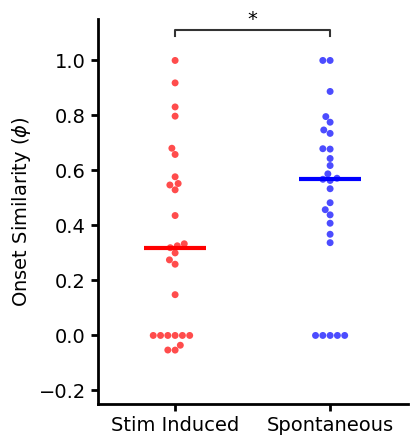

In [16]:
fig = plot_seizure_similarity(ch_similarity_df,agreement='MCC',sz_level=False,typical=None,annot_stats=True,combiner=COMBINER)
fig.savefig(ospj(figpath,"ch_sz_similarity.pdf"),bbox_inches='tight')

In [17]:
# plot_ks_similarity(ch_similarity_df)

In [18]:
all_stim_annots = []
all_spont_annots = []
annot_type = 'ueo'
con_type = 'loose'
example_pt = 'HUP257'
group = sz_annots[sz_annots.patient == example_pt]
group.sort_values(ascending=False,by='stim',inplace=True)
kappa_mat = np.zeros((len(group),len(group))); kappa_mat[:] = np.nan
group.reset_index(drop=True,inplace=True)
for i in range(len(group)):
    ch_mask = group.loc[i,f'{annot_type}_chs_{con_type}_mask']
    if group.loc[i,'stim'] == 1:
        print(f"{i} is stim")
    for j in range(i+1,len(group)):
        ch_mask2 = group.loc[j,f'{annot_type}_chs_{con_type}_mask']
        kappa_mat[i,j] = cohen_kappa_score(ch_mask,ch_mask2)

0 is stim


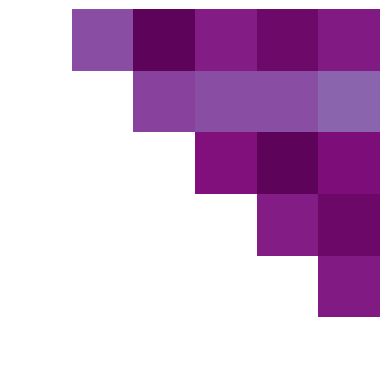

In [19]:
import matplotlib.patches as patches
fig,ax = plt.subplots()
plt.imshow(kappa_mat,cmap = 'BuPu')
# plt.colorbar()
plt.clim(0,1)
plt.xticks([])
plt.yticks([])
for spine in ax.spines.values():
            spine.set_visible(False)
plt.savefig(ospj(figpath,f'ueo_heatmap_pt-{example_pt}.pdf'),bbox_inches='tight')

In [20]:
# ch_spread_similarity_df = calculate_spread_similarity(sz_annots,first_annot='sz_chs',second_annot='sz_chs',paired=True)

In [21]:
# _ = plot_seizure_similarity(ch_spread_similarity_df,sz_level=False,agreement='MCC',typical=True)

### Seizure -- region

In [22]:
sz_annots_rs = sz_annots.dropna(axis=0,subset=['all_rs'])

In [23]:
r_similarity_df = calculate_seizure_similarity(sz_annots_rs,first_annot='ueo_rs_loose_mask',second_annot='ueo_rs_loose_mask')

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:5.684e-03 Stat=2.200e+01


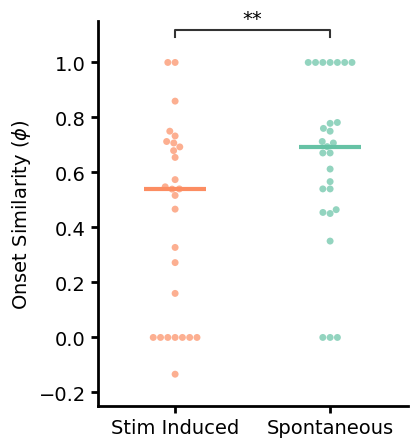

In [24]:
fig = plot_seizure_similarity(r_similarity_df,agreement='MCC',palette=pal,sz_level=False,typical=None,combiner=COMBINER)
fig.savefig(ospj(figpath,"region_sz_similarity.pdf"),bbox_inches='tight')

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:1.172e-02 Stat=0.000e+00
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:3.882e-01 Stat=2.800e+01


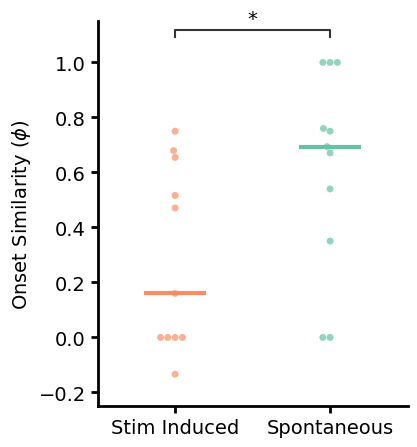

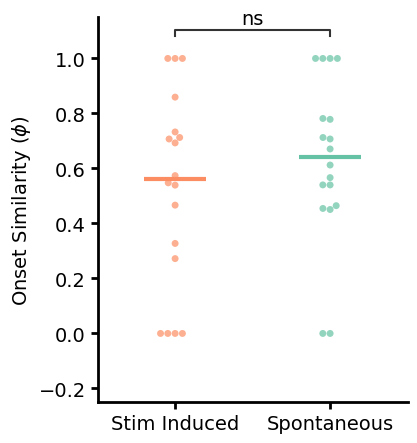

In [25]:
fig = plot_seizure_similarity(r_similarity_df,agreement='MCC',palette=pal,sz_level=False,typical=False,combiner=COMBINER)
fig.savefig(ospj(figpath,"region_sz_similarity_atypical.pdf"),bbox_inches='tight')
fig = plot_seizure_similarity(r_similarity_df,agreement='MCC',palette=pal,sz_level=False,typical=True,combiner=COMBINER)
fig.savefig(ospj(figpath,"region_sz_similarity_typical.pdf"),bbox_inches='tight')

### Region spread

In [26]:
def total_sz_recruitment(row):
    szing_rs = np.unique(row.sz_rs)
    szing_rs_mask = np.isin(row.all_rs,row.sz_rs)
    return sum(szing_rs_mask)/len(szing_rs_mask)*100
# def total_sz_recruitment(row):
#     szing_rs_mask = row.ueo_rs_loose_mask
#     return sum(szing_rs_mask)/len(szing_rs_mask)*100
# def total_sz_recruitment(row):
#     szing_rs = np.unique(row.sz_rs)
#     noszing_rs = szing_rs[~np.isin(szing_rs,row.ueo_rs_loose)]
#     noall_rs = row.all_rs[~np.isin(row.all_rs,row.ueo_rs_loose)]
#     szing_rs_mask = np.isin(row.all_rs,noszing_rs)
#     return sum(szing_rs_mask)/len(szing_rs_mask)*100

def pt_total_sz_recruitment(group):
    ret_dict = dict(Recruitment=[],stim=[],typical=[],patient=[])
    for _,stim_row in group.loc[group.stim == 1,:].iterrows():
        ret_dict['patient'].append(stim_row.patient),
        ret_dict['stim'].append(stim_row.stim)
        ret_dict['Recruitment'].append(total_sz_recruitment(stim_row))
        ret_dict['typical'].append(stim_row.typical)
        # Now paired spontaneous seizure
        ret_dict['patient'].append(stim_row.patient),
        ret_dict['stim'].append(0)
        ret_dict['Recruitment'].append(group[group.stim == 0].apply(total_sz_recruitment,axis=1).mean())
        ret_dict['typical'].append(stim_row.typical)
        
    return pd.DataFrame(ret_dict) 

In [27]:
sz_annots_rs.columns

Index(['patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset', 'offset',
       'threshold', 'ueo_chs_strict', 'ueo_chs_loose', 'sec_chs_strict',
       'sec_chs_loose', 'sz_chs', 'sz_times', 'all_channels', 'typical',
       'stim_channels', 'all_rs', 'sz_rs', 'ueo_chs_strict_mask',
       'ueo_rs_strict_mask', 'ueo_rs_strict', 'ueo_chs_loose_mask',
       'ueo_rs_loose_mask', 'ueo_rs_loose', 'sec_chs_strict_mask',
       'sec_rs_strict_mask', 'sec_rs_strict', 'sec_chs_loose_mask',
       'sec_rs_loose_mask', 'sec_rs_loose'],
      dtype='object')

In [28]:
recruitment_df = sz_annots_rs.groupby(['patient']).apply(pt_total_sz_recruitment)#.reset_index().rename(columns={0:'Recruitment'})
# sz_annots_rs['Recruitment'] = sz_annots_rs.apply(total_sz_recruitment,axis=1)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.057e-03 Stat=1.580e+02


Text(-16.736111111111114, 0.5, 'Recruitment (%)')

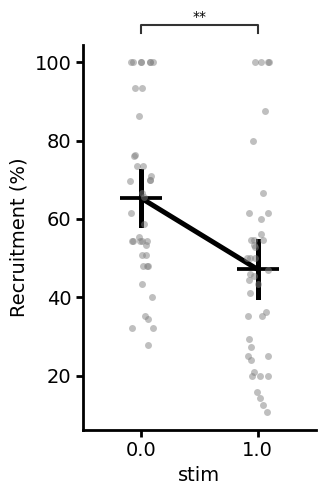

In [29]:
fig,ax = plt.subplots(figsize=(3,5))
ax = sns.pointplot(recruitment_df,x='stim',y='Recruitment',color='black',marker='_',markersize=30)
sns.stripplot(recruitment_df,x='stim',y='Recruitment',ax=ax,alpha=0.5,color='gray')
sns.despine()
annotator = Annotator(ax,[(True,False)],data=recruitment_df,x='stim',y='Recruitment')
annotator.configure(test='Wilcoxon',loc='outside',text_format='star',comparisons_correction='Benjamini-Hochberg')
annotator.apply_and_annotate()
plt.ylabel('Recruitment (%)')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_0 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.690e-02 (ns) U_stat=1.160e+02
0_1 vs. 1_1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.611e-02 U_stat=3.775e+02
0_0 vs. 1_0: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.315e-03 U_stat=2.040e+02


Text(-16.736111111111114, 0.5, 'Recruitment (%)')

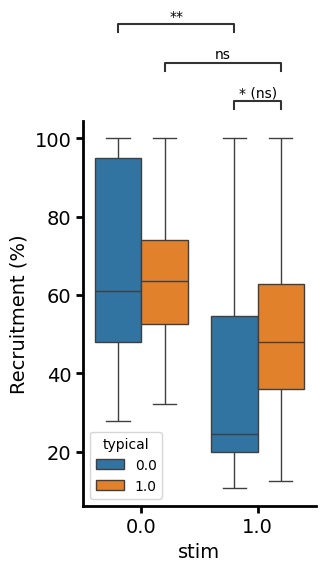

In [30]:
fig,ax = plt.subplots(figsize=(3,5))
ax = sns.boxplot(recruitment_df,x='stim',y='Recruitment',hue='typical')
# sns.stripplot(recruitment_df,x='stim',y='Recruitment',ax=ax,alpha=0.2,hue='typical')
sns.despine()
annotator = Annotator(ax,[((0,1),(1,1)),((0,0),(1,0)),((1,0),(1,1))],data=recruitment_df,x='stim',y='Recruitment',hue='typical',hue_order=[0,1],order=[0,1])
annotator.configure(test='Mann-Whitney',loc='outside',text_format='star',comparisons_correction='Benjamini-Hochberg')
annotator.apply_and_annotate()
plt.ylabel('Recruitment (%)')

### Bootstrapping

In [31]:
# print(sz_annots_rs.iloc[-1,-1],sz_annots_rs.iloc[-1,8])

In [32]:
# def boot_function(input_region,n_boots=1000):
#     np.random.seed(0)
#     seizure_counts = {}
#     n_boots = 1000
#     regions = np.atleast_1d(input_region).reshape(-1,)
#     # Perform 100 bootstraps
#     for _ in range(n_boots):
#         bootstrap_sample = np.random.choice(regions, size=len(regions), replace=True)
#         for region in np.unique(bootstrap_sample):
#             if region in seizure_counts:
#                 seizure_counts[region] += 1
#             else:
#                 seizure_counts[region] = 1

#     # Calculate the probability of each region being the true seizure region
#     probabilities = {region: count / n_boots for region, count in seizure_counts.items()}
#     most_likely = max(probabilities, key = probabilities.get) if len(probabilities)>0 else []
#     # return np.array([key for key in probabilities.keys() if probabilities[key] > 0.75])
#     return most_likely

# def mask_function(row):
#     return np.array([l in row.ueo_rs_boot for l in np.atleast_1d(row.all_rs)])
    

In [33]:
# sz_annots_rs['ueo_rs_boot'] = sz_annots_rs['ueo_rs_strict'].apply(boot_function)

In [34]:
# def surgical_parcelate(region_list):
#     surgical_labels = []
#     for label in np.atleast_1d(region_list):
#         if isinstance(label,float):
#             label = "EmptyLabel"
#         label = label.lower()
#         if ("emptylabel" in label) or ("white" in label):
#             surgical_label = "EmptyLabel"
#         elif ("amygdala" in label) or ("hippocampus" in label):
#             if "left" in label:
#                 surgical_label = 'left mesial temporal'
#             else:
#                 surgical_label = 'right mesial temporal'
#         elif ("temporal" in label) or ("fusiform" in label) or ("entorhinal" in label) or ("parahippocampal" in label):
#             if "left" in label:
#                 surgical_label = 'left temporal neocortex'
#             else:
#                 surgical_label = 'right temporal neocortex'
#         else:
#             if "left" in label:
#                 surgical_label = 'left other neocortex'
#             else:
#                 surgical_label = 'right other neocortex'
#         surgical_labels.append(surgical_label)
#     return surgical_labels

In [35]:
# sz_annots_rs['ueo_rs_boot_mask'] = sz_annots_rs.apply(mask_function,axis=1)

In [36]:
# boot_similarity_df = calculate_seizure_similarity(sz_annots_rs,first_annot='ueo_rs_boot_mask',second_annot='ueo_rs_boot_mask')

In [37]:
# plot_seizure_similarity(boot_similarity_df,agreement='F1',palette=pal,sz_level=False, binary=True)

## Seizure spread timing

### Channels

In [38]:
time_points =  np.arange(0,60.5,0.5)
def calculate_fraction(seizure_times, time_points = np.arange(0,60.5,.5)):
    fractions = []
    num_channels = seizure_times.shape[1]
    for t in time_points:
        fraction_seizing = (np.sum((seizure_times <= t) & (seizure_times >=0), axis=1)-np.sum(seizure_times < 0,axis=1)) / (num_channels-np.sum(seizure_times < 0,axis=1))
        fractions.append(fraction_seizing)
    return np.array(fractions).T  # Transpose to have seizures as rows and time points as columns

In [39]:
def calc_spont2stim(sz_annots,time_points = np.arange(0,60.5,0.5), typical=None):
    all_pts = []
    all_fraction_ts = []
    all_typical = []
    for pt,group in sz_annots.groupby("patient"):
        stim_szs = group[group.stim == 1]
        spont_szs = group[group.stim == 0]
        for idx,st_sz in stim_szs.iterrows():
            # Now, for each stim seizure I want to iterate through each spontaneous seizure:
            onset_locs = st_sz.ueo_chs_strict # can change to other channel types but this makes the most sense
            if len(onset_locs.shape) == 0:
                onset_locs = np.array([str(onset_locs)])
            all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
            for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
                # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
                locs = sp_sz.sz_chs
                times = sp_sz.sz_times
                # all_pts.append(pt) # SPNT SEIZURE LEVEL
                for k,st_loc in enumerate(onset_locs):
                    loc_idx = st_loc == locs
                    if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                        all_st_sp_spreads[j,k] = times[loc_idx]
                # This gives me an array that is spont seizures x stim onset channels and each element is the time that the spont seizure started seizing in that stim onset channel
                # I can try averaging across stim onset times for those that it started seizing in?
                # I can also just treat it as an independent data point to plot
            fraction_ts = calculate_fraction(all_st_sp_spreads,time_points)
            # all_fraction_ts.append(fraction_ts) # SPNT SEIZURE LEVEL
            all_pts.append(pt) # STIMSZ LEVEL
            all_typical.append(st_sz.typical)
            # all_fraction_ts.append(np.percentile(fraction_ts,COMBINER,axis=0)) # STIMSZ LEVEL
            all_fraction_ts.append(np.median(fraction_ts,axis=0))

    stim_spread_df = pd.DataFrame(np.array(all_fraction_ts),columns=time_points)
    nan_idxs = stim_spread_df.isna().any(axis=1)
    stim_spread_df = stim_spread_df.loc[~nan_idxs,:]
    # stim_spread_df = pd.DataFrame(np.concatenate(all_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
    stim_spread_df['patient'] = np.array(all_pts)[~nan_idxs]
    stim_spread_df['typical'] = np.array(all_typical)[~nan_idxs]

    stim_spread_df_long = stim_spread_df.melt(id_vars=['patient','typical'], var_name='Time', value_name='Fraction')
    
    return stim_spread_df_long

In [40]:
def calc_null_spont2stim(sz_annots, n_perm = 50, time_points = np.arange(0,60.5,0.5), typical=None):
    set_seed(2358)
    # Now need to iterate through patinets, then interate through seizures that are stim
    all_pts = []
    all_typical = []
    null_fraction_ts = []
    for pt,group in sz_annots.groupby("patient"):
        stim_szs = group[group.stim == 1]
        spont_szs = group[group.stim == 0]
        for idx,st_sz in stim_szs.iterrows():
            onset_locs = st_sz.ueo_chs_strict # can change to other channel types but this makes the most sense
            if len(onset_locs.shape) == 0:
                onset_locs = np.array([str(onset_locs)])
            null_n = len(onset_locs)
            for _ in range(n_perm):
                if null_n == 0:
                    null_locs = []
                else:
                    sample_chs = np.array([r for r in np.atleast_1d(st_sz.all_channels)])
                    null_locs = sample_chs[np.random.randint(0,len(sample_chs),null_n)]
                null_st_sp_spreads = np.ones((len(spont_szs),len(null_locs)))*60000
                for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
                    # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
                    locs = sp_sz.sz_chs
                    times = sp_sz.sz_times
                    # all_pts.append(pt) # SEIZURE LEVEL
                    for k,st_loc in enumerate(null_locs):
                        loc_idx = st_loc == locs
                        if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                            null_st_sp_spreads[j,k] = times[loc_idx]
                fraction_ts = calculate_fraction(null_st_sp_spreads,time_points)
                # null_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
                # null_fraction_ts.append(np.percentile(fraction_ts,COMBINER,axis=0))
                null_fraction_ts.append(np.median(fraction_ts,axis=0))
                all_typical.append(st_sz.typical) 
                all_pts.append(pt) 
    null_spread_df = pd.DataFrame(np.array(null_fraction_ts),columns=time_points)

    # null_spread_df = pd.DataFrame(np.concatenate(null_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
    null_spread_df['patient'] = all_pts
    null_spread_df['typical'] = all_typical
    null_spread_df_long = null_spread_df.melt(id_vars=['patient','typical'], var_name='Time', value_name='Fraction')
    return null_spread_df_long

In [41]:
def calc_spont2spont(sz_annots,time_points = np.arange(0,60.5,0.5)):
    all_pts = []
    all_typical = []
    spont_fraction_ts = []
    for pt,group in sz_annots.groupby("patient"):
        stim_szs = group[group.stim==1]
        any_typical = np.unique(stim_szs.typical)
        if len(any_typical) == 2:
            any_typical = 2
        else:
            any_typical = any_typical[0]
        spont_szs = group[group.stim == 0]
        for idx,key_sz in spont_szs.iterrows():
            # Now, for each spontatneous seizure I want to iterate through each other spontaneous seizure:
            onset_locs = key_sz.ueo_chs_strict
            if len(onset_locs.shape) == 0:
                onset_locs = np.array([str(onset_locs)])
            
            all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
            for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
                # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
                locs = sp_sz.sz_chs
                times = sp_sz.sz_times
                for k,key_loc in enumerate(onset_locs):
                    loc_idx = key_loc == locs
                    if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                        all_st_sp_spreads[j,k] = times[loc_idx]
            fraction_ts = calculate_fraction(all_st_sp_spreads,time_points)
            if np.isnan(fraction_ts).any():
                continue
            # spont_fraction_ts.append(fraction_ts)
            # all_pts.append([pt]*len(fraction_ts))
            spont_fraction_ts.append(np.nanmedian(fraction_ts,axis=0))
            all_pts.append(pt)
            all_typical.append(any_typical)

    spont_spread_df = pd.DataFrame(np.array(spont_fraction_ts),columns=time_points)
    spont_spread_df['patient'] = all_pts
    spont_spread_df['typical'] = all_typical
    spont_spread_df_long = spont_spread_df.melt(id_vars=['patient','typical'], var_name='Time', value_name='Fraction')
    return spont_spread_df_long

In [42]:
stim_spread_df_long = calc_spont2stim(sz_annots)
stim_spread_df_long['typical'] = stim_spread_df_long['typical'].map({0:'Atypical',1:'Typical'})

#### Null modeling

Need to figure out what are the odds of a random selection of regions equal to the number of stim onset regions seizing at that time point. This should sample from the all_rs based on the number of stim UEO regions

In [43]:
null_spread_df_long = calc_null_spont2stim(sz_annots)

In [44]:
null_is_sig = np.zeros((len(time_points),),dtype=bool)
for i,t in enumerate(time_points):
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    null_dist = null_spread_df_long[null_spread_df_long.Time == t]['Fraction']
    # pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
    pval = (np.sum(null_dist > np.mean(stim_dist))+1)/(len(null_dist)+1)
    # print(pval)
    if pval < 0.10:
        null_is_sig[i] = True


In [45]:
spont_spread_df_long = calc_spont2spont(sz_annots)

In [46]:
is_sig = np.zeros(len(time_points),)
for i,t in enumerate(time_points):
    spont_dist = spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction']
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    # pval = sc.stats.ttest_ind(spont_dist,stim_dist)[1]#,alternative='greater')[1]
    pval = sc.stats.mannwhitneyu(spont_dist,stim_dist)[1]#,alternative='greater')[1]

    if pval >= 0.10:
        is_sig[i] = True

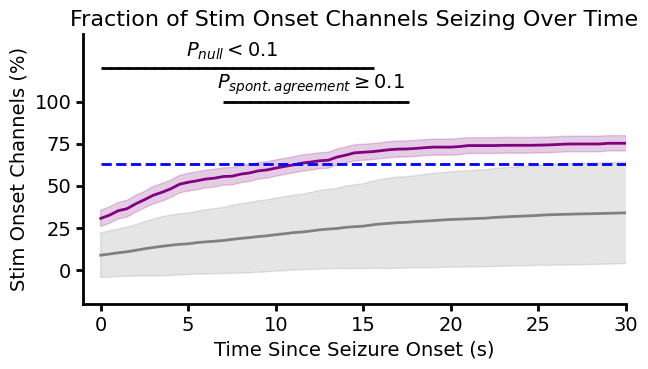

In [47]:
fig,ax = plt.subplots(figsize=(7, 3.5))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='purple',linewidth=2,err_style='band',errorbar=('se',1))
sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',
errorbar=('sd',1))
plotting_df = spont_spread_df_long.copy()
plotting_df = plotting_df[plotting_df.Time==0]
plotting_df.loc[:,'Time'] = -2
plt.title('Fraction of Stim Onset Channels Seizing Over Time')
plt.xlabel('Time Since Seizure Onset (s)')
# plt.ylabel('Onset Channels (%)')
plt.ylabel('Stim Onset Channels (%)')
sns.despine()
plt.xlim((-1,30))
plt.ylim((-.2,1.4))
null_y = 1.2
spont_y = 1
# Plot horizontal bars at y = 0.05
for i in range(len(is_sig) - 1):
    if is_sig[i]:
        if is_sig[i + 1]:
            ax.hlines(spont_y, time_points[i], time_points[i + 1]+0.1, color='black', linewidth=2)
        else:
            ax.hlines(spont_y, time_points[i], time_points[i], color='black', linewidth=2)
desc_x = np.mean(np.where(is_sig)[0]).astype(int)
plt.text(time_points[desc_x],spont_y+0.1,'$P_{spont. agreement} \geq 0.1$',fontsize='14',horizontalalignment='center',verticalalignment='center')

for i in range(len(null_is_sig) - 1):
    if null_is_sig[i]:
        if null_is_sig[i + 1]:
            ax.hlines(null_y, time_points[i], time_points[i + 1]+0.1, color='black', linewidth=2)
        else:
            ax.hlines(null_y, time_points[i], time_points[i], color='black', linewidth=2)
desc_x = np.mean(np.where(null_is_sig)[0]).astype(int)
plt.text(time_points[desc_x],null_y+0.1,'$P_{null} < 0.1$',fontsize='14',horizontalalignment='center',verticalalignment='center')

# star_x = np.where(is_sig)[0][-1]
plt.hlines(spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction'].mean(),0,60,colors='blue',linestyles='--',linewidth=2)
# plt.text(time_points[star_x],1.01,'*',fontsize='24',horizontalalignment='center')
# ymin,ymax = plt.ylim()
# plt.vlines(time_points[star_x],ymin,1,ls='--',color='k')
plt.yticks([0,.25,.5,.75,1],[0,25,50,75,100])
plt.savefig(ospj(figpath,'spont-stim_ueo_channel_recruitment.pdf'),bbox_inches='tight')

In [48]:
stim_spread_df_long['type'] = 'Stim'
null_spread_df_long['type'] = 'Null'
spont_spread_df_long['type'] = 'Spont'
temp_spont_df_long = spont_spread_df_long[spont_spread_df_long.Time==0].copy()

In [49]:
spont_df_list = []
for i in [0,5,10,15]:
    temp = temp_spont_df_long.copy()
    temp['Time'] = i
    spont_df_list.append(temp)
temp_spont_df_long = pd.concat(spont_df_list)

In [50]:
spread_df = pd.concat([stim_spread_df_long,null_spread_df_long,temp_spont_df_long])
spread_df = spread_df[spread_df.Time.isin([0,5,10,15])]

In [51]:
spread_df['Time'] = spread_df.Time.astype(int).astype(str)

In [52]:
spread_df['Time'].nunique()

4

In [53]:
# sns.boxplot(spread_df,x='Time',y='Fraction',hue='type',palette=['gray','red','blue'],hue_order=['Null','Stim','Spont'],order=[0,5,10,15],legend=False,fill=False,gap=0.3)
# sns.despine()
# plt.ylabel('Seizing Channels (%)')
# plt.xlabel('')


In [54]:
# sns.boxplot(spread_df,x='Time',y='Fraction',hue='typical',palette=['#7300b7','#da8e00'],hue_order=['Atypical','Typical'],order=[0,5,10,15],legend=False,fill=False,gap=0.3)
# sns.despine()
# plt.ylabel('Seizing Channels (%)')
# plt.xlabel('')

### Semiology

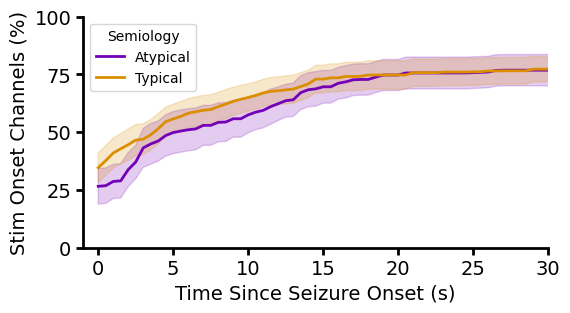

In [55]:
fig,ax = plt.subplots(figsize=(6, 3))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',hue='typical',hue_order=['Atypical','Typical'],linewidth=2,err_style='band',errorbar=('se',1), palette = ['#7300b7','#da8e00'])
plt.ylabel('Onset Channels (%)')
plt.xlabel('Time Since Seizure Onset (s)')
plt.ylabel('Stim Onset Channels (%)')

plt.yticks([0,.25,.5,.75,1],[0,25,50,75,100])
plt.xlim([-1,30])
plt.legend(title='Semiology')
sns.despine()
plt.savefig(ospj(figpath,'spont-stim_spread_semiology.pdf'),bbox_inches='tight')

In [56]:
typical_sig = np.zeros(len(time_points),)
ds = np.zeros(len(time_points),)

for i,t in enumerate(time_points):
    typ_dist = stim_spread_df_long[(stim_spread_df_long.Time == t) & (stim_spread_df_long.typical == 'Typical')]['Fraction']
    atyp_dist = stim_spread_df_long[(stim_spread_df_long.Time == t) & (stim_spread_df_long.typical == 'Atypical')]['Fraction']
    
    # pval = sc.stats.ttest_ind(spont_dist,stim_dist)[1]#,alternative='greater')[1]
    pval = sc.stats.mannwhitneyu(typ_dist,atyp_dist)[1]#,alternative='greater')[1]
    print(pval)
    ds[i] = cohens_d(typ_dist,atyp_dist)
    if pval < 0.1:
        typical_sig[i] = True

0.27824933668161356
0.21138626345578815
0.15715063403643648
0.13446239655122802
0.28669270425040183
0.43767744669573905
0.7396202153741387
0.7294710561129805
0.6578899206339278
0.638263216889513
0.6381366961322412
0.6678127584912732
0.6577388228483468
0.6182233971715487
0.6678716711278473
0.6478487124642317
0.6572084025688226
0.6078575068479515
0.6078575068479515
0.45393978940547675
0.5061740733744613
0.5059932489612629
0.4545371652195662
0.5607647636120794
0.6180244292022962
0.6978897007634024
0.7815667148689325
1.0
1.0
0.8889231136255986
0.9110346473406339
0.9110303929424072
0.9777142021940993
0.9551369668197978
0.8881521070678912
0.8881521070678912
0.977463968368941
0.932463761559073
0.8543083082360395
0.8543083082360395
0.8543083082360395
0.6598453168918036
0.7425279845289778
0.7425279845289778
0.7425279845289778
0.7425279845289778
0.7425279845289778
0.7425279845289778
0.7425279845289778
0.7425279845289778
0.7643364943812166
0.7643364943812166
0.7643364943812166
0.7105248203325967


In [57]:
d_df = pd.DataFrame(np.hstack((time_points.reshape(-1,1),ds.reshape(-1,1))),columns=['Time','Cohen\'s d'])
def time_bins(val):
    if val < 5:
        return 0
    if val < 10:
        return 1
    else:
        return 2
d_df['Time'] = d_df.Time.apply(time_bins)

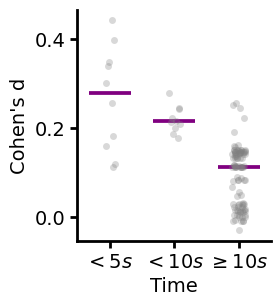

In [58]:
_,ax = plt.subplots(figsize=(2.5,3))
sns.pointplot(d_df,x='Time',y='Cohen\'s d',color='purple',estimator='median',marker='_',markersize=30,errorbar=None,linestyle='none')
sns.stripplot(d_df,x='Time',y='Cohen\'s d',color='gray',alpha=0.3)
sns.despine()
ax.set_xticks([0,1,2],['$< 5 s$', '$< 10 s$', '$\geq 10 s$'])
ax.set_yticks([0,.2,.4])
plt.savefig(ospj(figpath,'semiology_effect_time.pdf'),bbox_inches='tight')

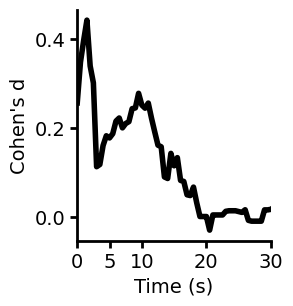

In [59]:
fig,ax = plt.subplots(figsize=(2.5,3))
ax.plot(time_points,ds,color='black',linewidth=4)
sns.despine()
# ax.axvline(10,linestyle='--',color='purple')
ax.set_yticks([0,.2,.4])
plt.xticks([0,5,10,20,30])
plt.xlim([0,30])
plt.xlabel('Time (s)')
plt.ylabel('Cohen\'s d')
plt.savefig(ospj(figpath,'semiology_effect_time_continuous.pdf'),bbox_inches='tight')

### Regions

Goal is to create a lineplot with error bar that has the percent of the stim seizure onset zone channels recruited on the y axis and the time since onset on the x axis.
For each stim seizure I need to create that signal. Really i'll have a signal for each stim-spont pair
If I have the time varying % seizing signal for each stim-spont pair I can calculate average across time for a stim seizure
Need to change each 
For each stim seizure:
    extract stim seizure onset zones
    For each spontaneous seizure in the same patient:
        Save time when each of the stim seizure onset regions started seizing in spontaneous seizure

In [60]:
# Converting the sz_chs into sz_rs
def ch2r(row,electrode_regions):
    sz_chs = row.sz_chs
    sz_times = row.sz_times
    electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(sz_chs)]['label']])
    sz_locs = []
    sz_loc_times = []
    for loc in np.unique(electrode_locals):
        loc_inds = loc == electrode_locals
        loc_times = sz_times[loc_inds]
        sz_loc_times.append(min(loc_times))
        sz_locs.append(loc)
    row.sz_locs = np.array(sz_locs)
    row.sz_loc_times = np.array(sz_loc_times)
    return row
        
sz_annots[["sz_locs","sz_loc_times"]] = pd.NA
for pt,group in sz_annots.groupby("patient"):
    region_path = get_rpath(prodatapath,pt)
    electrode_regions = pd.read_pickle(region_path)
    # electrode_regions = surgical_parcellation(electrode_regions)
    group = group.apply(lambda x: ch2r(x,electrode_regions),axis=1)
    sz_annots_rs.loc[group.index,["sz_locs","sz_loc_times"]] = group.loc[:,["sz_locs","sz_loc_times"]]

In [61]:
time_points =  np.arange(0,60.5,.5)
def calculate_fraction(seizure_times, time_points = np.arange(0,60.5,.5)):
    fractions = []
    num_channels = seizure_times.shape[1]
    for t in time_points:
        fraction_seizing = (np.sum((seizure_times <= t) & (seizure_times >=0), axis=1)-np.sum(seizure_times < 0,axis=1)) / (num_channels-np.sum(seizure_times < 0,axis=1))
        fractions.append(fraction_seizing)
    return np.array(fractions).T  # Transpose to have seizures as rows and time points as columns

In [62]:
# Now need to iterate through patinets, then iterate through seizures that are stim
all_pts = []
all_fraction_ts = []
for pt,group in sz_annots_rs.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        # Now, for each stim seizure I want to iterate through each spontaneous seizure:
        onset_locs = st_sz.ueo_rs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            # all_pts.append(pt) # SEIZURE LEVEL
            for k,st_loc in enumerate(onset_locs):
                loc_idx = st_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
            # This gives me an array that is spont seizures x stim onset channels and each element is the time that the spont seizure started seizing in that stim onset channel
            # I can try averaging across stim onset times for those that it started seizing in?
            # I can also just treat it as an independent data point to plot
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        # all_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
        all_pts.append(pt)
        # all_fraction_ts.append(np.percentile(fraction_ts,COMBINER,axis=0))
        all_fraction_ts.append(np.median(fraction_ts,axis=0))

stim_spread_df = pd.DataFrame(np.array(all_fraction_ts),columns=time_points)

# stim_spread_df = (stim_spread_df>0.5).astype(float)
# stim_spread_df = pd.DataFrame(np.concatenate(all_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
nan_idxs = stim_spread_df.isna().any(axis=1)
stim_spread_df = stim_spread_df.loc[~nan_idxs,:]
stim_spread_df['patient'] = np.array(all_pts)[~nan_idxs]
stim_spread_df_long = stim_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

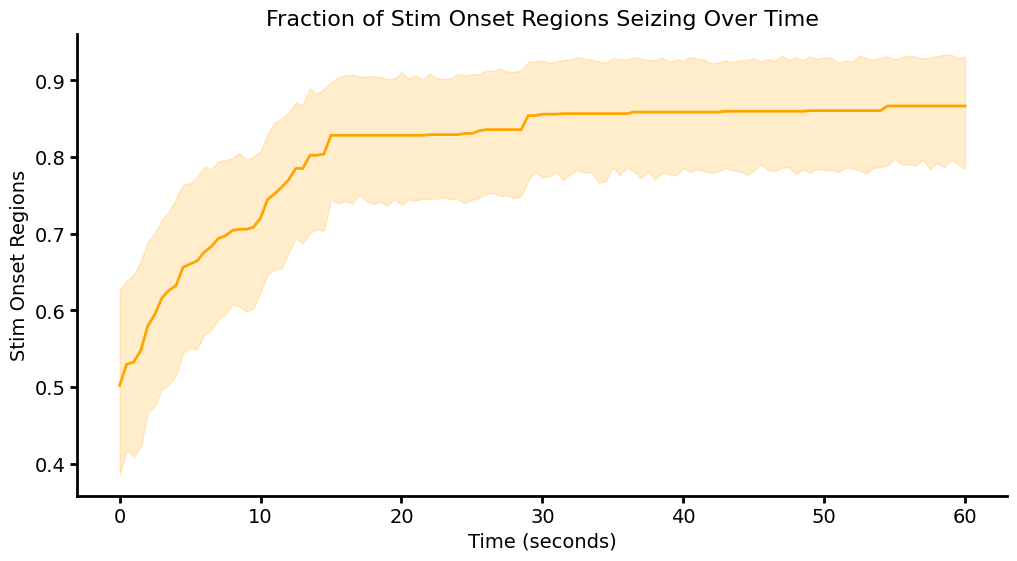

In [63]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Stim Onset Regions')
sns.despine()
# plt.ylim((0,1))

#### Null modeling

Need to figure out what are the odds of a random selection of regions equal to the number of stim onset regions seizing at that time point. This should sample from the all_rs based on the number of stim UEO regions

In [64]:
set_seed(2358)
# Now need to iterate through patinets, then interate through seizures that are stim
all_pts = []
null_fraction_ts = []
for pt,group in sz_annots_rs.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        onset_locs = st_sz.ueo_rs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        null_n = len(onset_locs)
        for _ in range(50):
            if null_n == 0:
                null_locs = []
            else:
                sample_rs = np.array([r for r in np.atleast_1d(st_sz.all_rs) if r != 'EmptyLabel'])
                null_locs = sample_rs[np.random.randint(0,len(sample_rs),null_n)]
            null_st_sp_spreads = np.ones((len(spont_szs),len(null_locs)))*60000
            for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
                # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
                locs = sp_sz.sz_locs
                times = sp_sz.sz_loc_times
                # all_pts.append(pt) # SEIZURE LEVEL
                for k,st_loc in enumerate(null_locs):
                    loc_idx = st_loc == locs
                    if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                        null_st_sp_spreads[j,k] = times[loc_idx]
            fraction_ts = calculate_fraction(null_st_sp_spreads)
            # null_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
            # null_fraction_ts.append(np.percentile(fraction_ts,COMBINER,axis=0))
            null_fraction_ts.append(np.median(fraction_ts,axis=0))
            all_pts.append(pt) 
null_spread_df = pd.DataFrame(np.array(null_fraction_ts),columns=time_points)
# null_spread_df = (null_spread_df > 0.5).astype(float)
# null_spread_df = pd.DataFrame(np.concatenate(null_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
null_spread_df['patient'] = all_pts
null_spread_df_long = null_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [65]:
is_sig = np.zeros((len(time_points),),dtype=bool)
for i,t in enumerate(time_points):
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    null_dist = null_spread_df_long[null_spread_df_long.Time == t]['Fraction']
    # pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
    pval = (np.sum(null_dist > np.mean(stim_dist))+1)/(len(null_dist)+1)
    if pval < 0.05:
        is_sig[i] = True

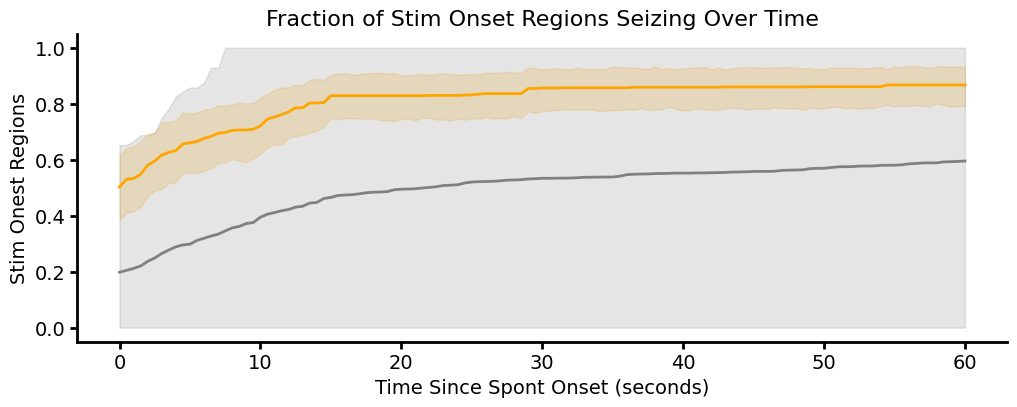

In [66]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange')
sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',errorbar=lambda x: (np.percentile(x,5),np.percentile(x,95)))
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Stim Onest Regions')
sns.despine()
# plt.xlim((0,15))
# plt.ylim((0,1))
# Plot horizontal bars at y = 0.05
for i in range(len(is_sig) - 1):
    if is_sig[i]:
        if is_sig[i + 1]:
            ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
        else:
            ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
# ymin,ymax = plt.ylim()
# if sum(is_sig) > 0:
#     star_x = np.where(is_sig)[0][0]
#     plt.text(time_points[star_x],1.01,'*',fontsize='24',horizontalalignment='center')
#     plt.vlines(time_points[star_x],ymin,1,ls='--',color='k')
# plt.savefig(ospj(figpath,'stim_ueo_region_recruitment.pdf'),bbox_inches='tight')

#### Calculating fraction of onset regions at 5 seconds comparing null model to stim seizure onset to every other spontaneous seizure onset

In [67]:
# Now need to iterate through patients, then interate through seizures that are stim
all_pts = []
spont_fraction_ts = []
for pt,group in sz_annots_rs.groupby("patient"):
    spont_szs = group[group.stim == 0]
    for idx,key_sz in spont_szs.iterrows():
        # Now, for each spontatneous seizure I want to iterate through each other spontaneous seizure:
        onset_locs = key_sz.ueo_rs_strict
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            for k,key_loc in enumerate(onset_locs):
                loc_idx = key_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        if np.isnan(fraction_ts).any():
            continue
        # spont_fraction_ts.append(fraction_ts)
        # all_pts.append([pt]*len(fraction_ts))
        # spont_fraction_ts.append(np.nanpercentile(fraction_ts,COMBINER,axis=0))
        spont_fraction_ts.append(np.nanmedian(fraction_ts,axis=0))
        all_pts.append(pt)

spont_spread_df = pd.DataFrame(np.array(spont_fraction_ts),columns=time_points)
# spont_spread_df = (spont_spread_df > 0.5).astype(float)
spont_spread_df['patient'] = all_pts
spont_spread_df_long = spont_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [68]:
is_sig = np.zeros((int(60.5/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,60.5,0.5)):
    spont_dist = spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction']
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(spont_dist,stim_dist)[1]
    if pval >= 0.05:
        is_sig[i] = True

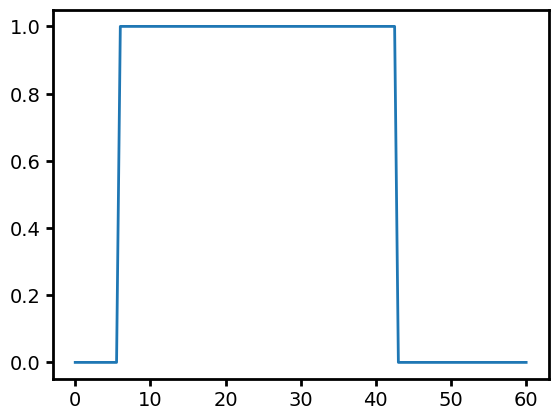

In [69]:
plt.plot(time_points,is_sig)

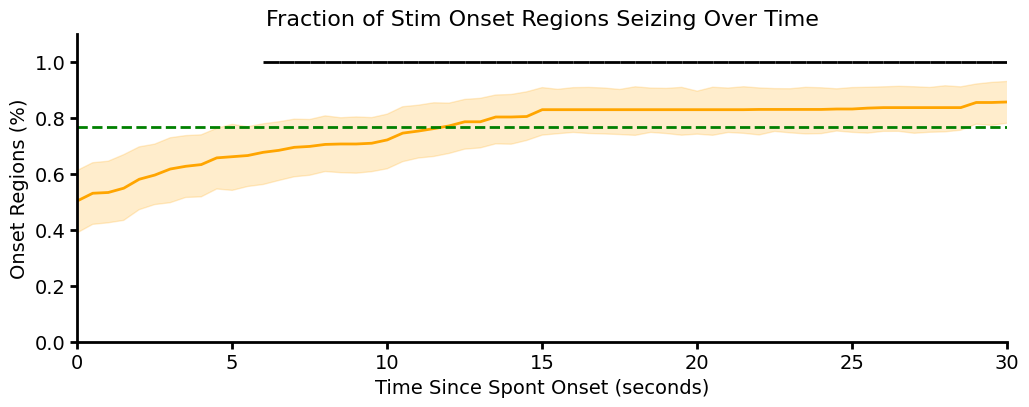

In [70]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange',linewidth=2,err_style='band')
# sns.lineplot(data=spont_spread_df_long, x='Time', y='Fraction',color='green',linewidth=2,err_style='band')
plotting_df = spont_spread_df_long.copy()
plotting_df = plotting_df[plotting_df.Time==0]
plotting_df.loc[:,'Time'] = -2
# sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',linewidth=2)
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Onset Regions (%)')
sns.despine()
plt.xlim((0,30))
plt.ylim((0,1.1))
# Plot horizontal bars at y = 0.05
for i in range(len(is_sig) - 1):
    if is_sig[i]:
        if is_sig[i + 1]:
            ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
        else:
            ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
# star_x = np.where(is_sig)[0][0]
# print(time_points[star_x])
# plt.text(time_points[star_x],1.01,'*',fontsize='24',horizontalalignment='center')
# ymin,ymax = plt.ylim()
# plt.vlines(time_points[star_x],ymin,1,ls='--',color='k')
plt.hlines(spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction'].mean(),0,60,colors='green',linestyles='--',linewidth=2)
plt.savefig(ospj(figpath,'spont-stim_ueo_region_recruitment.pdf'),bbox_inches='tight')

## Predicting Electrographic Similarity

### Calculating seizure level metadata

Make a dataframe with the following columns: Patient, stim seizure, spontaneous seizure, stim onset regions, spontaneous onset regions, kappa, stim seizure duration, hippocampal localization? 

273 is atypical

In [71]:
def model_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
    annot_list = ["kappa","F1","MCC","patient","IEEGname","approximate_onset","stim_sz_length","stim_sz_spread"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            ch_mask = group.loc[i,first_annot].reshape(-1,)
            if group.loc[i,'stim'] == 1:
                for j in range(len(group)):
                    if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                        continue
                    ch_mask2 = group.loc[j,second_annot].reshape(-1,)
                    annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
                    annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
                    annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))
                    annot_dict["patient"].append(pt)
                    annot_dict["IEEGname"].append(group.loc[i,'iEEG_ID'])
                    annot_dict["approximate_onset"].append(group.loc[i,'approximate_onset'])
                    annot_dict["stim_sz_length"].append(group.loc[i,'offset']-group.loc[i,'approximate_onset'])
                    annot_dict['stim_sz_spread'].append(len(group.loc[i,'sz_chs'])/len(group.loc[i,'all_channels']))
                    
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

In [72]:
model_df = model_seizure_similarity(sz_annots,first_annot='ueo_rs_strict_mask',second_annot='ueo_rs_strict_mask',paired = False)
model_df = model_df.rename(columns={'IEEGname':'iEEG_ID'})
model_df = model_df.sort_values('approximate_onset')

Skipped [] due to insufficient spontaneous seizures


In [73]:
model_df_wtypical = pd.merge_asof(model_df,
                                    seizures_df[['approximate_onset','patient',"iEEG_ID","to_annotate","typical"]],
                                    on='approximate_onset',by=['patient','iEEG_ID'],
                                    tolerance = 240,
                                    direction='nearest')

In [74]:
model_df_wtypical.typical = model_df_wtypical.typical == 1

In [75]:
metadata_table = pd.read_csv(ospj(metapath,'stim_seizure_information - metadata-4.csv')).loc[:,["record_id","hupsubjno",
                                                                                            "Laterality","unifocal",
                                                                                            "localization","duration",
                                                                                            "outcome","lesional","age_at_onset"]]
metadata_table['stim_sz'] = metadata_table['hupsubjno'].apply(int).isin(patient_table.ptID.apply(lambda x: int(x[3:])))
metadata_table['mtle'] = metadata_table.localization.apply(lambda x: 'MTLE' in x if not isinstance(x,float) else False)
# metadata_table['mtle'] = metadata_table.localization == 'MTLE'
metadata_table["unifocal"] = metadata_table.unifocal == 1
metadata_table["lesional"] = metadata_table.lesional > 0
metadata_table["ptID"] = "HUP" + metadata_table["hupsubjno"].astype(str)
# metadata_table.loc[metadata_table.unifocal == 0,'mtle'] = pd.NA

In [76]:
kiddata_table = pd.read_csv(ospj(metapath,'CHOP_metadata.csv'))
kiddata_table['duration'] = kiddata_table['duration of epilepsy prior to stim (y)']
kiddata_table['age_at_onset'] = kiddata_table['age at epilepsy onset']
kiddata_table['unifocal'] = kiddata_table.unifocal == 1
kiddata_table['mtle'] = kiddata_table.mtle == 1
kiddata_table['lesional'] = kiddata_table.lesional == 1
# kiddata_table.head()

In [77]:
all_metadata_table = pd.concat((metadata_table,kiddata_table))[['ptID','unifocal','mtle','outcome','duration','age_at_onset','lesional','stim_sz']]
all_metadata_table['adult'] = all_metadata_table.ptID.apply(lambda x: 'HUP' in x)
all_metadata_table.head()

,ptID,unifocal,mtle,outcome,duration,age_at_onset,lesional,stim_sz,adult
0,HUP211,False,True,NaN,11.3,12.0,True,0,True
1,HUP212,False,False,NaN,13.9,42.0,True,0,True
2,HUP213,True,True,NaN,19.1,2.0,True,0,True
3,HUP214,False,True,NaN,8.6,32.0,False,0,True
4,HUP216,True,False,1.0,21.1,3.0,False,0,True


In [78]:
# Join the two tables and make linear model!
lm_df = pd.merge(model_df_wtypical,all_metadata_table[['ptID','mtle','outcome','unifocal','lesional','adult','duration','age_at_onset']],left_on='patient',right_on='ptID',how='inner').drop('ptID',axis=1)

In [79]:
combiner=COMBINER
def percentile(x,combiner=combiner):
    return np.percentile(x,combiner,method='nearest')
lm_df['age'] = lm_df['duration'] + lm_df['age_at_onset']
lm_df_grouped = lm_df.groupby('approximate_onset')
lm_df_left = lm_df_grouped[[l for l in lm_df.columns if l not in ['MCC','F1','kappa']]].max()
lm_df_left['MCC'] = lm_df_grouped['MCC'].apply(percentile)
lm_df_left['F1'] = lm_df_grouped['F1'].apply(percentile)
lm_df_left['kappa'] = lm_df_grouped['kappa'].apply(percentile)
lm_df_left.reset_index(drop=True,inplace=True)

In [80]:
lm_df_left.dropna(axis=0,subset=['MCC','F1','mtle','unifocal','typical','lesional'],how='any',inplace=True)
lm_df_left.head()

,patient,iEEG_ID,approximate_onset,stim_sz_length,stim_sz_spread,to_annotate,typical,mtle,outcome,unifocal,lesional,adult,duration,age_at_onset,age,MCC,F1,kappa
0,HUP229,HUP229_phaseII,1109.40,67.51,0.414634,1.0,True,True,0.0,True,True,True,32.900000,8.0,40.900000,0.440386,0.571429,0.432432
1,CHOP035,CHOPCCEP_035,2872.35,26.71,0.156977,1.0,True,True,NaN,True,True,False,2.360712,15.0,17.360712,0.471405,0.533333,0.363636
2,CHOP026,CHOPCCEP_026,3608.77,133.79,0.380000,NaN,False,True,1.0,False,False,False,2.777550,14.0,16.777550,0.000000,0.000000,NaN
3,HUP230,HUP230_phaseII,3860.24,18.16,0.132075,1.0,False,True,1.0,True,True,True,31.500000,20.0,51.500000,0.679366,0.666667,0.631579
4,CHOP026,CHOPCCEP_026,4838.94,37.90,0.280000,1.0,True,True,1.0,False,False,False,2.777550,14.0,16.777550,0.540062,0.500000,0.451613


In [81]:
len(lm_df_left)

41

### Univariate analyses

In [82]:
center_mdl = smf.ols(formula='MCC ~ adult*mtle',data=lm_df_left).fit()
print(center_mdl.summary())

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     4.620
Date:                Mon, 12 May 2025   Prob (F-statistic):            0.00764
Time:                        09:46:42   Log-Likelihood:                -11.874
No. Observations:                  41   AIC:                             31.75
Df Residuals:                      37   BIC:                             38.60
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [83]:
age_mdl = smf.ols(formula='MCC ~mtle*age',data=lm_df_left).fit()
dur_mdl = smf.ols(formula='MCC ~ mtle*duration',data=lm_df_left).fit()
onset_mdl = smf.ols(formula='MCC ~ mtle*age_at_onset',data=lm_df_left).fit()
print(age_mdl.rsquared_adj, age_mdl.f_pvalue)
print(dur_mdl.rsquared_adj,dur_mdl.f_pvalue)
print(onset_mdl.rsquared_adj,onset_mdl.f_pvalue)
print(onset_mdl.summary())

0.16143257872336225 0.0250551007460416
-0.061302533862573894 0.8614361384462451
0.23249624819311698 0.005657229864456321
                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     4.938
Date:                Mon, 12 May 2025   Prob (F-statistic):            0.00566
Time:                        09:46:42   Log-Likelihood:                -10.835
No. Observations:                  40   AIC:                             29.67
Df Residuals:                      36   BIC:                             36.42
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.

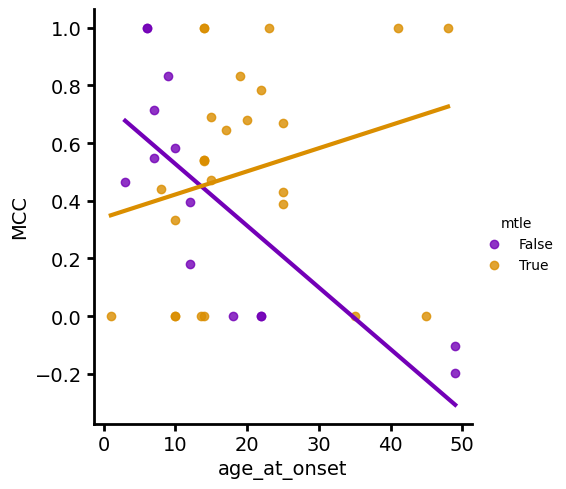

In [84]:
sns.lmplot(data=lm_df_left,x='age_at_onset',y='MCC',
x_partial='mtle',
 hue='mtle',ci=False,
 palette=['#7300b7','#da8e00'])

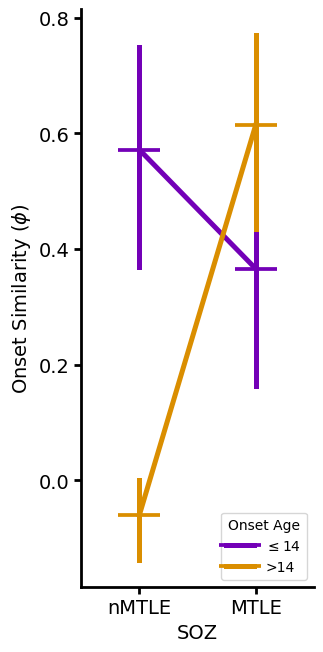

In [85]:
plot_df = lm_df_left.copy()
split = plot_df.age_at_onset.median()
plot_df['onset_age'] = (lm_df_left.age_at_onset>split).map({False:f'$\leq${int(split)}',True:f'>{int(split)}'})
_,ax = plt.subplots(figsize=(3,7.5))
sns.pointplot(
    data = plot_df,
    x='mtle',
    y='MCC',
    hue='onset_age',
    marker='_',markersize=30,
    palette=['#7300b7','#da8e00'],
    ax=ax,
    )
plt.ylabel('Onset Similarity ($\phi$)')
sns.despine()
plt.xticks([0,1],['nMTLE','MTLE'])
plt.xlabel('SOZ')
plt.legend(title='Onset Age')
plt.savefig(ospj(figpath,'stim_univariate_mtle_by_age.pdf'),bbox_inches='tight')
print()

In [86]:
age_mdl = smf.ols(formula='MCC ~ mtle*onset_age',data=plot_df).fit()
print(age_mdl.summary())

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     5.923
Date:                Mon, 12 May 2025   Prob (F-statistic):            0.00209
Time:                        09:46:43   Log-Likelihood:                -10.356
No. Observations:                  41   AIC:                             28.71
Df Residuals:                      37   BIC:                             35.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [87]:
age_mdl = smf.ols(formula='MCC ~typical*adult',data=lm_df_left).fit()
print(age_mdl.summary())

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     3.118
Date:                Mon, 12 May 2025   Prob (F-statistic):             0.0376
Time:                        09:46:43   Log-Likelihood:                -13.775
No. Observations:                  41   AIC:                             35.55
Df Residuals:                      37   BIC:                             42.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [88]:
age_mdl = smf.ols(formula='MCC ~typical*age',data=lm_df_left).fit()
dur_mdl = smf.ols(formula='MCC ~ typical*duration',data=lm_df_left).fit()
onset_mdl = smf.ols(formula='MCC ~ typical*age_at_onset',data=lm_df_left).fit()

print(age_mdl.rsquared_adj,age_mdl.f_pvalue)
print(dur_mdl.rsquared_adj,dur_mdl.f_pvalue)
print(onset_mdl.rsquared_adj,onset_mdl.f_pvalue)
print(center_mdl.summary())
# print(lm_df_left[['age','duration','age_at_onset','typical','MCC']].corr())

0.13756278468985328 0.03984408417902235
0.24746178265743413 0.004047683985300446
0.26434041179732704 0.002748627979635502
                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     4.620
Date:                Mon, 12 May 2025   Prob (F-statistic):            0.00764
Time:                        09:46:43   Log-Likelihood:                -11.874
No. Observations:                  41   AIC:                             31.75
Df Residuals:                      37   BIC:                             38.60
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      

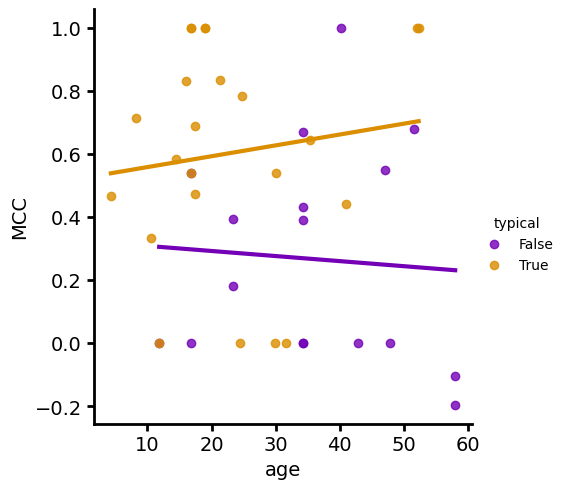

In [89]:
sns.lmplot(data=lm_df_left,x='age',y='MCC',
# x_partial='mtle',
 hue='typical',ci=False,
 palette=['#7300b7','#da8e00'])

#### All

MannwhitneyuResult(statistic=233.0, pvalue=0.30419968593785884)
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.042e-01 U_stat=1.570e+02


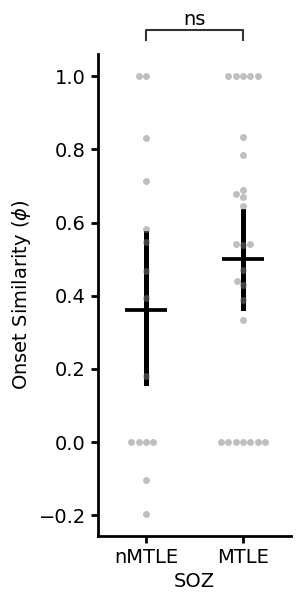

MannwhitneyuResult(statistic=155.0, pvalue=0.17082848038123244)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.708e-01 U_stat=2.590e+02


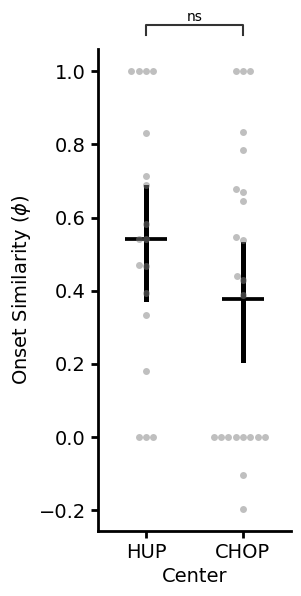

MannwhitneyuResult(statistic=301.5, pvalue=0.009365050908278523)
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.365e-03 U_stat=1.065e+02


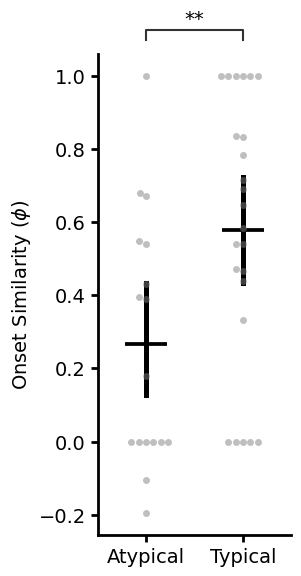

MannwhitneyuResult(statistic=152.0, pvalue=0.5328785339962228)


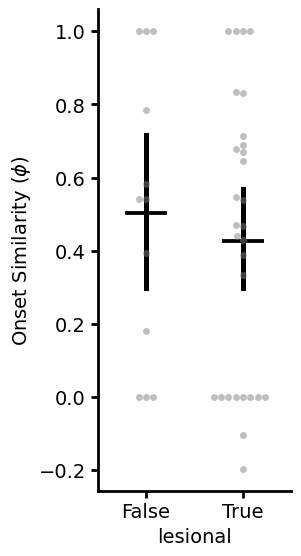

SignificanceResult(statistic=0.1791138445876697, pvalue=0.2624959875877051)


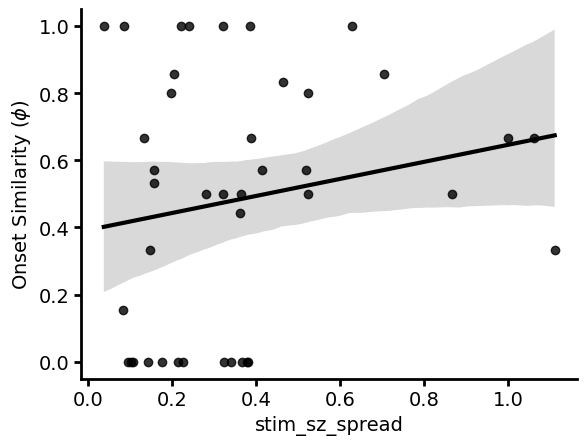

SignificanceResult(statistic=-0.06758845866488228, pvalue=0.6745773344456825)


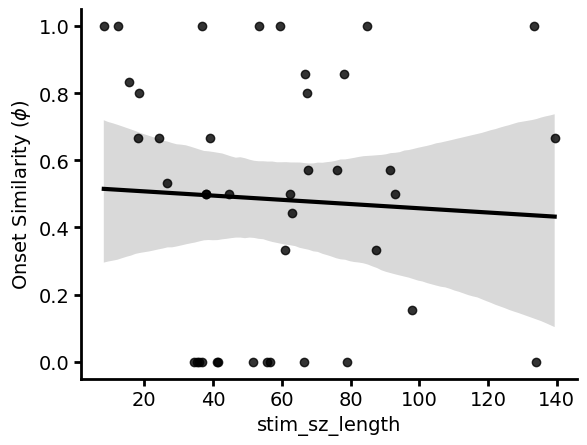

SignificanceResult(statistic=nan, pvalue=nan)


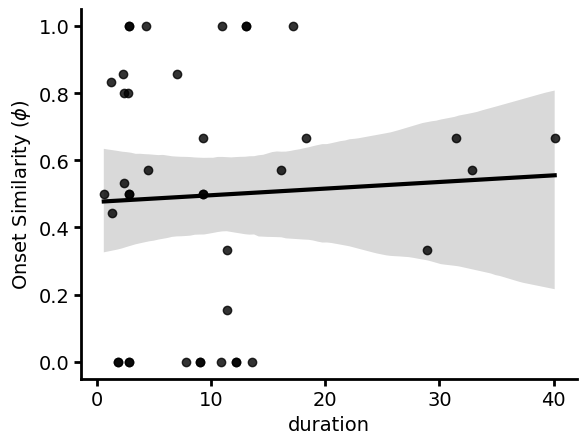

In [111]:
for col in ['mtle','adult','typical','lesional','stim_sz_spread','stim_sz_length','duration']:
    if lm_df_left[col].nunique() <= 3:
        print(sc.stats.mannwhitneyu(lm_df_left[lm_df_left[col]]['MCC'],lm_df_left[~lm_df_left[col]]['MCC']))
        _,ax = plt.subplots(figsize=(2.5,6.25))
        sns.swarmplot(lm_df_left,x=col,y='MCC',color='gray',alpha=0.5,ax=ax)
        sns.pointplot(lm_df_left,x=col,y='MCC',marker='_',linestyles='none',markersize=30,color='black',ax=ax)
        plt.ylabel('Onset Similarity ($\phi$)')
        sns.despine()
        if col == 'typical':
            plt.xticks([0,1],['Atypical','Typical'],
            # rotation=45
            )
            plt.xlabel('')
            # plt.ylim([-.1,1.2])
            # plt.title('Seizure-Level Seizure Similarity')
            annotator = Annotator(ax,[(False,True)],data=lm_df_left,x=col,y='MCC')
            annotator.configure(test='Mann-Whitney',
            loc='outside',
            text_format='star',
            fontsize=14,
            pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                            [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
            annotator.apply_and_annotate()
            plt.savefig(ospj(figpath,'stim_univariate_typical.pdf'),bbox_inches='tight')
        
        if col == 'mtle':
            plt.xticks([0,1],['nMTLE','MTLE'],
            # rotation=0
            )
            plt.xlabel('SOZ')
            # plt.ylim([-.1,1.2])
            # plt.title('Seizure-Level Seizure Similarity')
            annotator = Annotator(ax,[(False,True)],data=lm_df_left,x=col,y='MCC')
            annotator.configure(test='Mann-Whitney',
            loc='outside',
            text_format='star',
            fontsize=14,
            pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                            [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
            annotator.apply_and_annotate()
            plt.savefig(ospj(figpath,'stim_univariate_mtle.pdf'),bbox_inches='tight')
        if col == 'adult':
            plt.xticks([0,1],['HUP','CHOP'],rotation=0)
            plt.xlabel('Center')
            # plt.ylim([-.1,1.2])
            # plt.title('Seizure-Level Seizure Similarity')
            annotator = Annotator(ax,[(False,True)],data=lm_df_left,x=col,y='MCC')
            annotator.configure(test='Mann-Whitney',loc='outside',text_format='star')
            annotator.apply_and_annotate()
    else:
        print(sc.stats.spearmanr(lm_df_left[col].values,lm_df_left['F1'].values))
        sns.regplot(lm_df_left,x=col,y='F1',color='black')
        plt.ylabel('Onset Similarity ($\phi$)')
        sns.despine()

    plt.show()


#### By center

MannwhitneyuResult(statistic=96.0, pvalue=0.006964852298935776)
MannwhitneyuResult(statistic=28.0, pvalue=0.3031022495770712)
1.4579968259888139


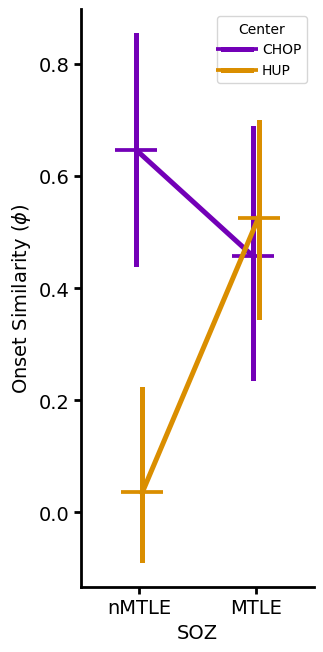

MannwhitneyuResult(statistic=86.0, pvalue=0.21977941258992384)
MannwhitneyuResult(statistic=56.5, pvalue=0.019564262898489122)
0.4817426218416786


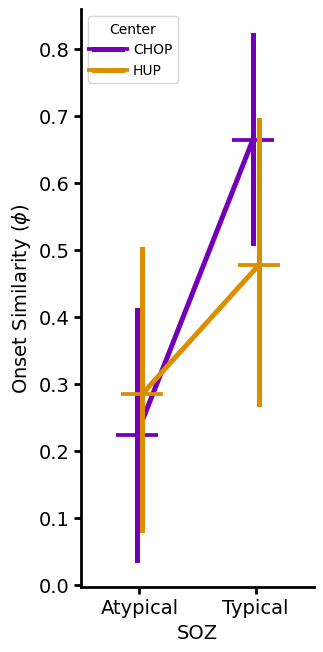

MannwhitneyuResult(statistic=32.0, pvalue=0.6482928461529711)
MannwhitneyuResult(statistic=41.0, pvalue=0.9642873967346467)


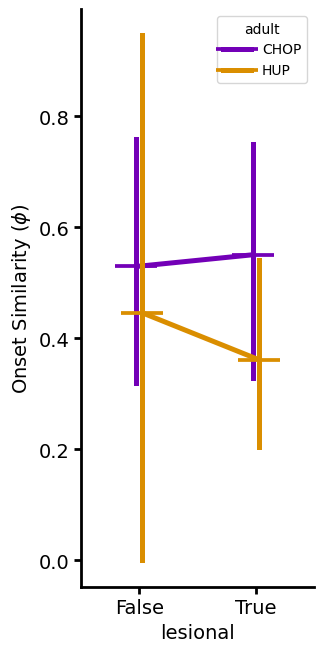

In [91]:
plot_df = lm_df_left.copy()
plot_df['adult'] = plot_df.adult.map({True:'HUP',False:'CHOP'})
# plot_df['adult'] = plot_df['age_at_onset'] > 25
for col in ['mtle','typical','lesional','stim_sz_spread','stim_sz_length']:
    if lm_df_left[col].nunique() <= 3:

        print(sc.stats.mannwhitneyu(lm_df_left[lm_df_left.adult][lm_df_left[col]]['MCC'],lm_df_left[lm_df_left.adult][~lm_df_left[col]]['MCC']))
        print(sc.stats.mannwhitneyu(lm_df_left[~lm_df_left.adult][lm_df_left[col]]['MCC'],lm_df_left[~lm_df_left.adult][~lm_df_left[col]]['MCC']))
        _,ax = plt.subplots(figsize=(3,7.5))
        sns.pointplot(plot_df,x=col,y='MCC',marker='_',markersize=30,hue='adult',dodge=True,palette=['#7300b7','#da8e00'])
        plt.ylabel('Onset Similarity ($\phi$)')
        sns.despine()
        if col == 'mtle':
            plt.xticks([0,1],['nMTLE','MTLE'])
            plt.xlabel('SOZ')
            print(cohens_d(lm_df_left[lm_df_left.adult][lm_df_left[col]]['MCC'],lm_df_left[lm_df_left.adult][~lm_df_left[col]]['MCC']))
            plt.legend(title='Center')
            plt.savefig(ospj(figpath,'stim_univariate_mtle_by_center.pdf'),bbox_inches='tight')
        if col == 'typical':
            plt.xticks([0,1],['Atypical','Typical'])
            plt.xlabel('SOZ')
            print(cohens_d(lm_df_left[lm_df_left.adult][lm_df_left[col]]['MCC'],lm_df_left[lm_df_left.adult][~lm_df_left[col]]['MCC']))
            plt.legend(title='Center')
            plt.savefig(ospj(figpath,'stim_univariate_typical_by_center.pdf'),bbox_inches='tight')

    plt.show()

### Recursive modeling

#### No MTLE

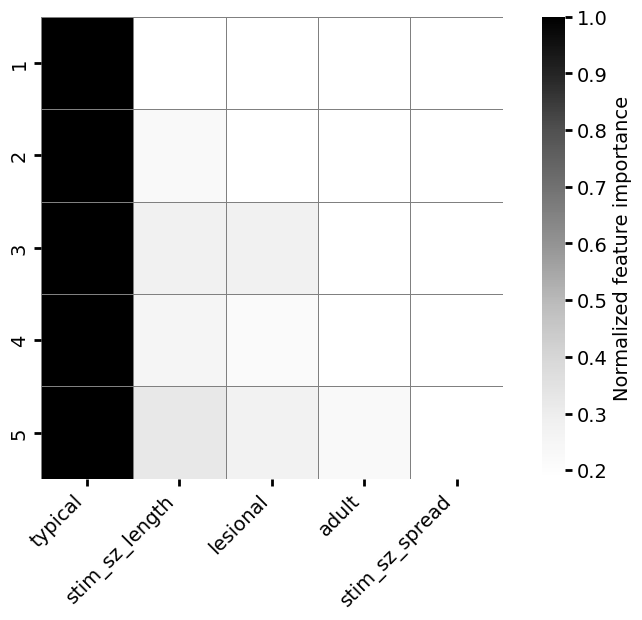

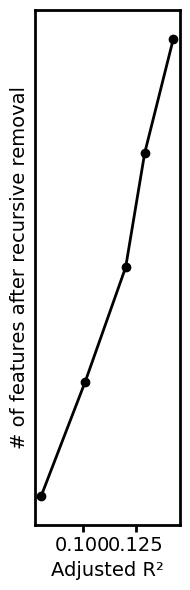

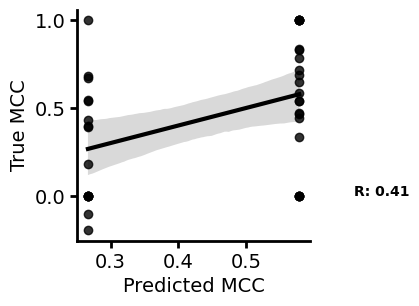

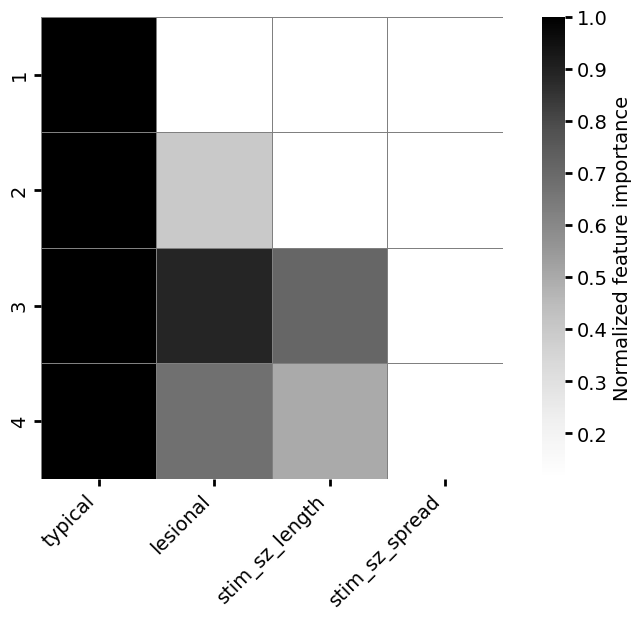

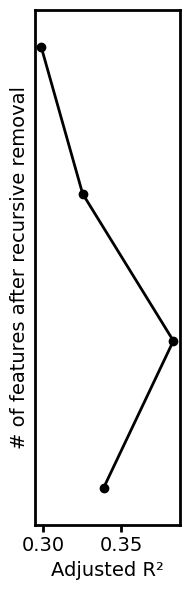

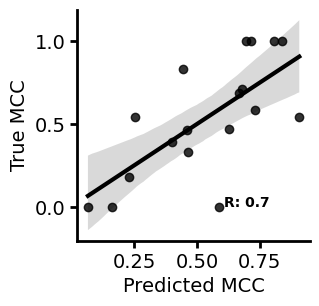

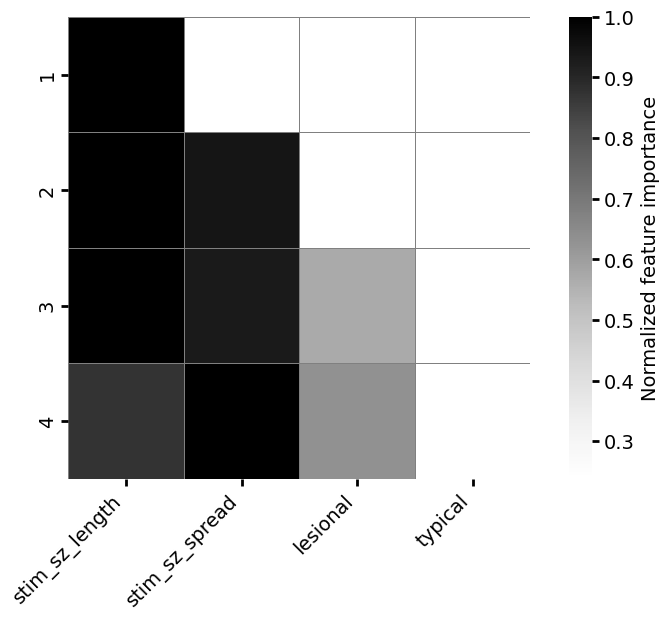

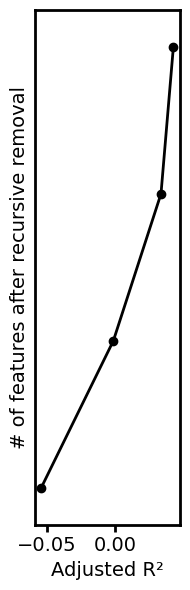

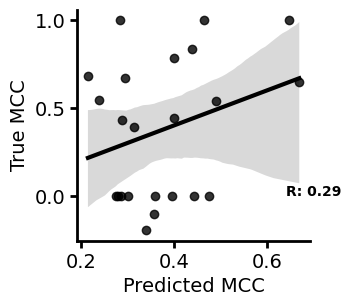

In [92]:
for mask in [[True]*len(lm_df_left),lm_df_left.adult==False, lm_df_left.adult==True]:
    dat = lm_df_left[mask].copy()
    
    if dat.adult.nunique() == 2:
        all_vars = ['adult','lesional', 'typical', 'stim_sz_length', 'stim_sz_spread']
    else:
        all_vars = ['lesional', 'typical', 'stim_sz_length', 'stim_sz_spread']

    dat = dat[all_vars+['MCC']]
    remaining_vars = all_vars.copy()

    # Store results
    adj_r2_list = []
    var_list = []
    tval_history = {}

    # Recursive elimination
    while len(remaining_vars) > 0:
        var_list.append(remaining_vars.copy())
        formula = 'MCC ~ ' + ' + '.join(remaining_vars)
        results = smf.ols(formula, data=dat).fit()

        adj_r2_list.append(results.rsquared_adj)
        tvals = results.tvalues.drop('Intercept').abs()
        tvals = results.tvalues.drop('Intercept').abs()
        # print(results.rsquared_adj,results.tvalues)
        # Map the true variable names
        mapped_tvals = {}
        for k, v in tvals.items():
            base = k.split('[')[0] if '[' in k else k
            mapped_tvals[base] = v

        # Reindex to keep consistent order and NaNs for dropped vars
        tval_history[len(remaining_vars)] = pd.Series(mapped_tvals).reindex(all_vars)

        # Drop least important feature
        if len(remaining_vars) > 1:
            to_remove = tvals.idxmin()
            if 'True' in to_remove:
                to_remove = to_remove.split('[')[0]
            remaining_vars.remove(to_remove)
        else:
            break

    # Create tval_df with fixed columns up front
    tval_df = pd.DataFrame.from_dict(tval_history, orient='index')[all_vars]
    tval_df.index = range(len(tval_df), 0, -1)

    # Normalize row-wise (preserves NaNs)
    tval_df_norm = tval_df.div(tval_df.max(axis=1), axis=0)
    # Build triangular mask
    # mask = np.triu(np.ones_like(tval_df_norm.values, dtype=bool), k=1)
    # Sort columns by their column-wise sum (descending)
    tval_df_norm = tval_df_norm[tval_df_norm.sum(axis=0).sort_values(ascending=False).index]

    # Invert the rows (e.g., from bottom to top)
    tval_df_norm = tval_df_norm.iloc[::-1]
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Heatmap of normalized t-values (importance)
    sns.heatmap(
        tval_df_norm,
        cmap='Greys',
        linewidths=0.5,
        linecolor='grey',
        square=True,
        cbar_kws={'label': 'Normalized feature importance'},
        xticklabels=tval_df_norm.columns,
        yticklabels=[f'{i}' for i in tval_df_norm.index],
        ax=ax
    )
    # ax.set_ylabel('# of features after recursive removal')
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.xticks(rotation=45, ha='right')

    fig, ax2 = plt.subplots(figsize=(2, 6))
    # Add R² curve
    ax2.plot(adj_r2_list, np.arange(len(adj_r2_list))+0.5, 'o-', color='black')
    plt.yticks([])
    # ax2.set_xlim(0.1, .3)
    ymax = len(adj_r2_list)-.25
    ax2.set_ylim([0.25,ymax])
    ax2.set_xlabel('Adjusted R²')
    ax2.set_ylabel('# of features after recursive removal')
    plt.tight_layout()
    plt.show()
    best_features = var_list[np.argmax(adj_r2_list)]
    formula = 'MCC ~ ' + ' + '.join(best_features)
    results = smf.ols(formula, data=dat).fit()
    predicted_mcc = results.predict(dat)
    fig,ax3 = plt.subplots(figsize=(3,3))
    # ax3.scatter(predicted_mcc,dat.MCC,c='k')
    sns.regplot(x=predicted_mcc,y=dat.MCC,color='black')
    ax3.set_xlabel('Predicted MCC')
    ax3.set_ylabel('True MCC')
    
    # ax3.plot([0,1],[0,1],c='k',linestyle='--')
    # plt.ylim([-.2,1.1])
    # plt.xlim([-.2,1.1])

    ax3.text(0.7,0, f'R: {np.round(np.corrcoef(predicted_mcc,dat.MCC.values)[0][1],2)}',fontweight='bold',ha='center')
    sns.despine()

#### MTLE

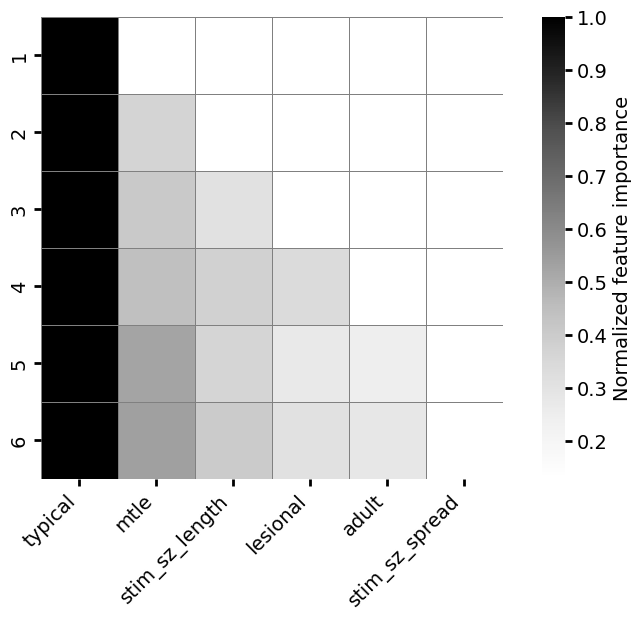

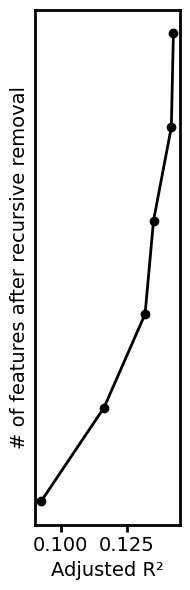

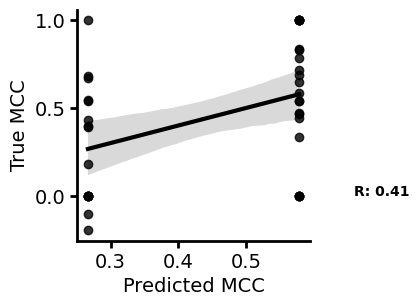

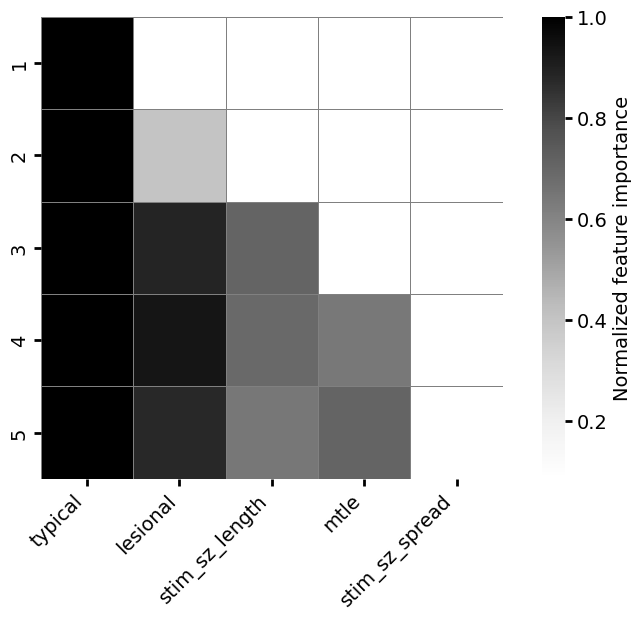

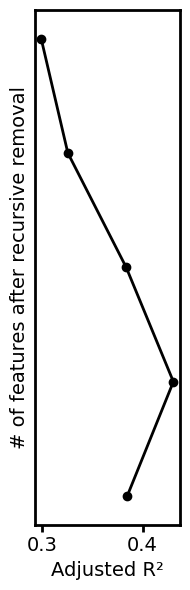

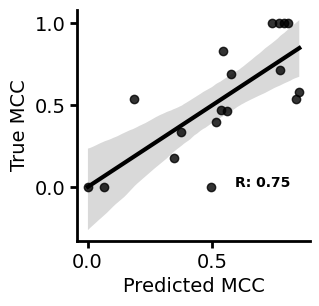

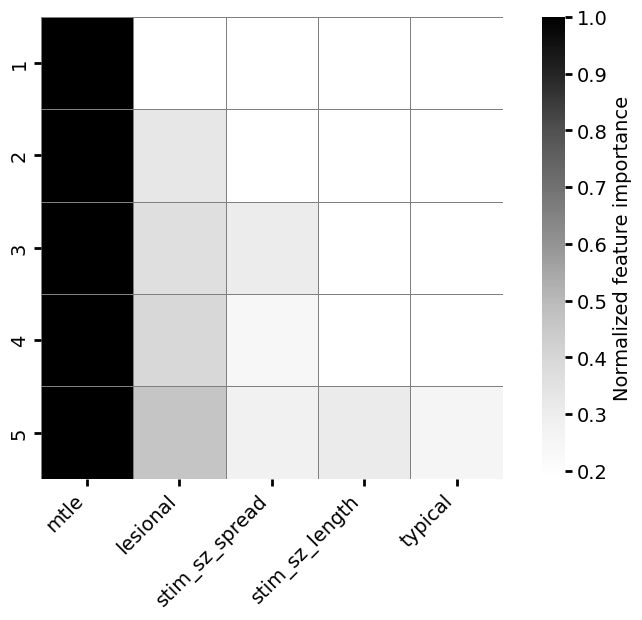

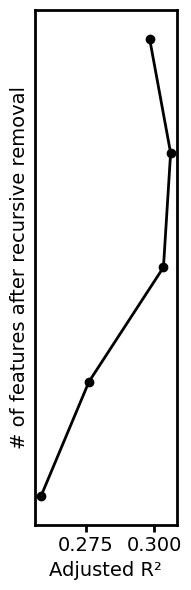

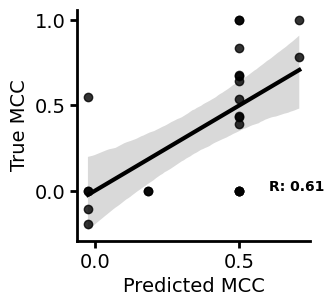

In [93]:
for mask in [[True]*len(lm_df_left),lm_df_left.adult==False, lm_df_left.adult==True]:
    dat = lm_df_left[mask].copy()
    
    if dat.adult.nunique() == 2:
        all_vars = ['mtle','adult','lesional', 'typical', 'stim_sz_length', 'stim_sz_spread']
    else:
        all_vars = ['mtle','lesional', 'typical', 'stim_sz_length', 'stim_sz_spread']

    dat = dat[all_vars+['MCC']]
    remaining_vars = all_vars.copy()

    # Store results
    adj_r2_list = []
    var_list = []
    tval_history = {}

    # Recursive elimination
    while len(remaining_vars) > 0:
        var_list.append(remaining_vars.copy())
        formula = 'MCC ~ ' + ' + '.join(remaining_vars)
        results = smf.ols(formula, data=dat).fit()

        adj_r2_list.append(results.rsquared_adj)
        tvals = results.tvalues.drop('Intercept').abs()
        tvals = results.tvalues.drop('Intercept').abs()
        # print(results.rsquared_adj,results.tvalues)
        # Map the true variable names
        mapped_tvals = {}
        for k, v in tvals.items():
            base = k.split('[')[0] if '[' in k else k
            mapped_tvals[base] = v

        # Reindex to keep consistent order and NaNs for dropped vars
        tval_history[len(remaining_vars)] = pd.Series(mapped_tvals).reindex(all_vars)

        # Drop least important feature
        if len(remaining_vars) > 1:
            to_remove = tvals.idxmin()
            if 'True' in to_remove:
                to_remove = to_remove.split('[')[0]
            remaining_vars.remove(to_remove)
        else:
            break

    # Create tval_df with fixed columns up front
    tval_df = pd.DataFrame.from_dict(tval_history, orient='index')[all_vars]
    tval_df.index = range(len(tval_df), 0, -1)

    # Normalize row-wise (preserves NaNs)
    tval_df_norm = tval_df.div(tval_df.max(axis=1), axis=0)
    # Build triangular mask
    # mask = np.triu(np.ones_like(tval_df_norm.values, dtype=bool), k=1)
    # Sort columns by their column-wise sum (descending)
    tval_df_norm = tval_df_norm[tval_df_norm.sum(axis=0).sort_values(ascending=False).index]

    # Invert the rows (e.g., from bottom to top)
    tval_df_norm = tval_df_norm.iloc[::-1]
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Heatmap of normalized t-values (importance)
    sns.heatmap(
        tval_df_norm,
        cmap='Greys',
        linewidths=0.5,
        linecolor='grey',
        square=True,
        cbar_kws={'label': 'Normalized feature importance'},
        xticklabels=tval_df_norm.columns,
        yticklabels=[f'{i}' for i in tval_df_norm.index],
        ax=ax
    )
    # ax.set_ylabel('# of features after recursive removal')
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.xticks(rotation=45, ha='right')

    fig, ax2 = plt.subplots(figsize=(2, 6))
    # Add R² curve
    ax2.plot(adj_r2_list, np.arange(len(adj_r2_list))+0.5, 'o-', color='black')
    plt.yticks([])
    # ax2.set_xlim(0.1, .3)
    ymax = len(adj_r2_list)-.25
    ax2.set_ylim([0.25,ymax])
    ax2.set_xlabel('Adjusted R²')
    ax2.set_ylabel('# of features after recursive removal')
    plt.tight_layout()
    plt.show()
    best_features = var_list[np.argmax(adj_r2_list)]
    formula = 'MCC ~ ' + ' + '.join(best_features)
    results = smf.ols(formula, data=dat).fit()
    predicted_mcc = results.predict(dat)
    fig,ax3 = plt.subplots(figsize=(3,3))
    # ax3.scatter(predicted_mcc,dat.MCC,c='k')
    sns.regplot(x=predicted_mcc,y=dat.MCC,color='black')
    ax3.set_xlabel('Predicted MCC')
    ax3.set_ylabel('True MCC')
    
    # ax3.plot([0,1],[0,1],c='k',linestyle='--')
    # plt.ylim([-.2,1.1])
    # plt.xlim([-.2,1.1])

    ax3.text(0.7,0, f'R: {np.round(np.corrcoef(predicted_mcc,dat.MCC.values)[0][1],2)}',fontweight='bold',ha='center')
    sns.despine()

### MVLM function

In [94]:
marker_style = MarkerStyle('d')
marker_style._transform.rotate_deg(90)

In [95]:
def plot_linear_models(dat,variables,subset=''):
    formula = 'MCC ~ ' + ' + '.join(variables)
    results = smf.ols(formula, data=dat).fit()
    print(results.summary())
    tvals = results.tvalues
    pvals = results.pvalues
    lm_vars = results.params.index
    lm_vars = [var.split('[')[0] if '[' in var else var for var in lm_vars]

    data = {
    'Variable': lm_vars,
    't_statistic': tvals,
    'significant': pvals
    }

    df = pd.DataFrame(data)
    def sig_color(pval):
        if pval < 0.05:
            return 'red'
        elif pval < 0.10:
            return 'purple'
        else:
            return 'black'
    palette = [sig_color(pval) for pval in df['significant']][1:]

    # plot_order = ['Intercept','mtle[T.True]','unifocal[T.True]','typical[T.True]','stim_sz_length','stim_sz_spread']
    # Plotting
    fig,ax = plt.subplots(figsize=(3, 6))
    # sns.barplot(
    #     data=df,
    #     y='Variable',
    #     x='t_statistic',
    #     palette=palette,
    #     # palette = ['blue','blue','blue','blue','blue'],
    #     orient='h',
    #     order=variables,
    # )
    sns.pointplot(
            data=df,
            y='Variable',
            x='t_statistic',
            palette=palette,
            # palette = ['blue','blue','blue','blue','blue'],
            orient='h',
            linestyle='none',
            order=variables,
            marker=marker_style
        )
    # Add a vertical line at t = 0 for reference
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel('t-statistic')
    plt.ylabel('')
    # if len(subset) > 0:
    #     plt.title(f'Predicting Electrographic Similarity ({subset})')
    # else:
    #     plt.title('Predicting Electrographic Similarity')
    # plt.yticks(plt.yticks()[0],['mTLE SOZ','Lesional','Unifocal','Typical','Sz Length','Sz Spread'])
    # plt.yticks(plt.yticks()[0],['Lesional','Typical','Sz Length','Sz Spread'])
    plt.yticks(plt.yticks()[0],variables)
    # plt.xticks(plt.xticks()[0],variables,rotation=60)
    if (subset=='HUP') and ('mtle' in variables):
        plt.text(0.7,0.8,f'$Adj. R^2$: {np.round(results.rsquared_adj,2)}',transform=ax.transAxes,ha='left',va='bottom',fontsize=14)
    else:
        plt.text(0.7,0.9,f'$Adj. R^2$: {np.round(results.rsquared_adj,2)}',transform=ax.transAxes,ha='left',va='bottom',fontsize=14)
    plt.xlim([-2,4])
    sns.despine()
    return fig,ax


In [112]:
def plot_interaction_models(dat,variables,subset='',var_names = None):
    formula = 'MCC ~ ' + ' + '.join(variables)
    results = smf.ols(formula, data=dat).fit()
    print(results.summary())
    tvals = results.tvalues
    pvals = results.pvalues
    lm_vars = results.params.index
    # lm_vars = [var.split('[')[0] if '[' in var else var for var in lm_vars]

    data = {
    'Variable': lm_vars,
    't_statistic': tvals,
    'significant': pvals
    }

    df = pd.DataFrame(data).iloc[1:,:]
    def sig_color(pval):
        if pval < 0.05:
            return 'red'
        elif pval < 0.10:
            return 'purple'
        else:
            return 'black'
            
    palette = [sig_color(pval) for pval in df['significant']]

    # plot_order = ['Intercept','mtle[T.True]','unifocal[T.True]','typical[T.True]','stim_sz_length','stim_sz_spread']
    # Plotting
    _,ax = plt.subplots(figsize=(2.5,6.25))
    
    sns.pointplot(
            data=df,
            y='Variable',
            x='t_statistic',
            palette=palette,
            # palette = ['blue','blue','blue','blue','blue'],
            orient='h',
            linestyle='none',
            order=df.index,
            marker=marker_style
        )
    # Add a vertical line at t = 0 for reference
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel('t-statistic')
    plt.ylabel('')
    
    plt.yticks(plt.yticks()[0],var_names)

    if (subset=='HUP') and ('mtle' in variables):
        plt.text(0.7,0.8,f'$Adj. R^2$: {np.round(results.rsquared_adj,2)}',transform=ax.transAxes,ha='left',va='bottom',fontsize=14)
    else:
        plt.text(0.7,0.9,f'$Adj. R^2$: {np.round(results.rsquared_adj,2)}',transform=ax.transAxes,ha='left',va='bottom',fontsize=14)
    plt.xlim([-4.5,4.5])
    plt.xticks([-2,0,2])
    sns.despine()
    return fig,ax


### Applying MVLM

#### All

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     3.118
Date:                Mon, 12 May 2025   Prob (F-statistic):             0.0376
Time:                        10:06:03   Log-Likelihood:                -13.775
No. Observations:                  41   AIC:                             35.55
Df Residuals:                      37   BIC:                             42.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

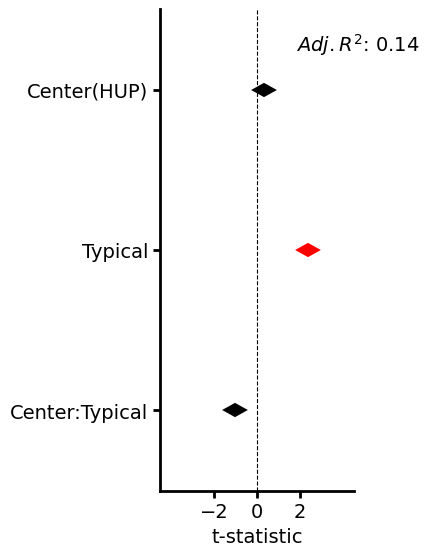

In [113]:
_ = plot_interaction_models(lm_df_left,['adult*typical'],var_names=['Center(HUP)','Typical','Center:Typical'])
plt.savefig(ospj(figpath,'interaction_center-typical.pdf'),bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     4.620
Date:                Mon, 12 May 2025   Prob (F-statistic):            0.00764
Time:                        10:06:04   Log-Likelihood:                -11.874
No. Observations:                  41   AIC:                             31.75
Df Residuals:                      37   BIC:                             38.60
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

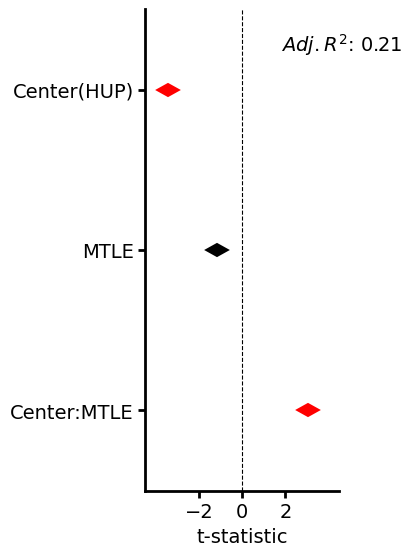

In [114]:
_ = plot_interaction_models(lm_df_left,['adult*mtle'],var_names=['Center(HUP)','MTLE','Center:MTLE'])
plt.savefig(ospj(figpath,'interaction_center-mtle.pdf'),bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     5.923
Date:                Mon, 12 May 2025   Prob (F-statistic):            0.00209
Time:                        10:06:05   Log-Likelihood:                -10.356
No. Observations:                  41   AIC:                             28.71
Df Residuals:                      37   BIC:                             35.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

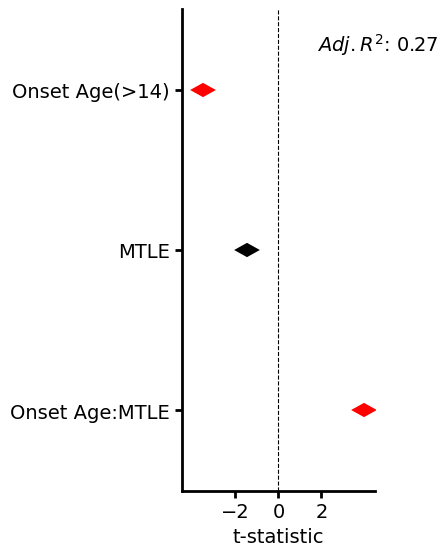

In [115]:
plot_df = lm_df_left.copy()
split = plot_df.age_at_onset.median()
plot_df['onset_age'] = (lm_df_left.age_at_onset>split).map({False:f'$\leq${int(split)}',True:f'>{int(split)}'})
_ = plot_interaction_models(plot_df,['onset_age*mtle'],var_names=['Onset Age(>14)','MTLE','Onset Age:MTLE'])
plt.savefig(ospj(figpath,'interaction_age-mtle.pdf'),bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     7.656
Date:                Mon, 12 May 2025   Prob (F-statistic):            0.00861
Time:                        09:46:49   Log-Likelihood:                -14.722
No. Observations:                  41   AIC:                             33.44
Df Residuals:                      39   BIC:                             36.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2665      0.086     

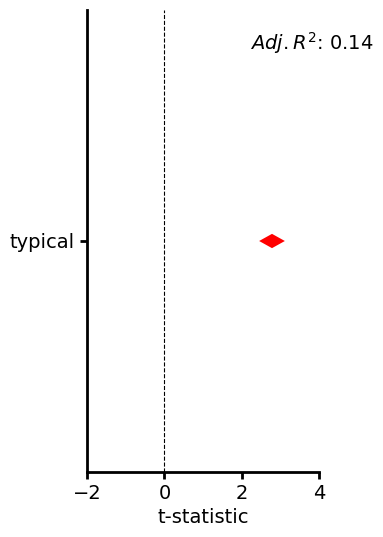

In [100]:
# _ = plot_linear_models(lm_df_left,['lesional','typical','stim_sz_length','stim_sz_spread'])
_ = plot_linear_models(lm_df_left,['typical'])

plt.savefig(ospj(figpath,'mvlm_all.pdf'),bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1.971
Date:                Mon, 12 May 2025   Prob (F-statistic):              0.107
Time:                        09:46:49   Log-Likelihood:                -13.311
No. Observations:                  41   AIC:                             38.62
Df Residuals:                      35   BIC:                             48.90
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3692      0.177  

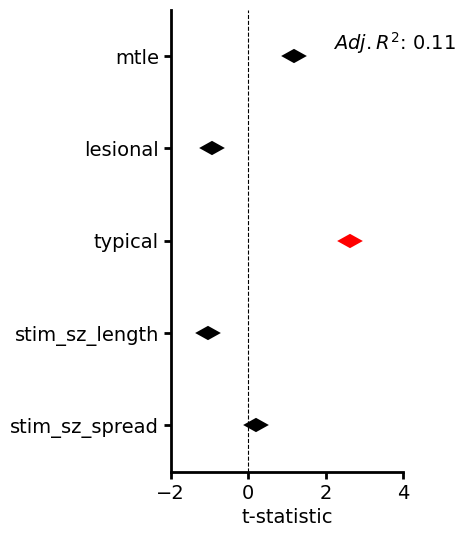

In [101]:
plot_linear_models(lm_df_left,['mtle','lesional','typical','stim_sz_length','stim_sz_spread'])
plt.savefig(ospj(figpath,'mvlm_mtle_all.pdf'),bbox_inches='tight')

#### Just HUP

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                 -0.054
Method:                 Least Squares   F-statistic:                    0.7164
Date:                Mon, 12 May 2025   Prob (F-statistic):              0.592
Time:                        09:46:49   Log-Likelihood:                -9.4475
No. Observations:                  23   AIC:                             28.89
Df Residuals:                      18   BIC:                             34.57
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1905      0.263  

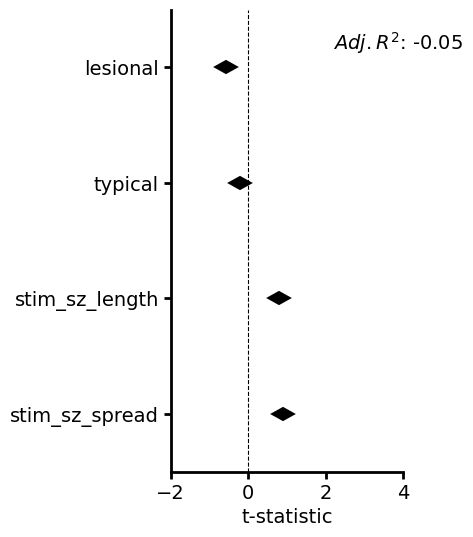

In [102]:
plot_linear_models(lm_df_left[lm_df_left.adult],['lesional','typical','stim_sz_length','stim_sz_spread'],subset='HUP')
plt.savefig(ospj(figpath,'mvlm_hup.pdf'),bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     2.535
Date:                Mon, 12 May 2025   Prob (F-statistic):             0.0687
Time:                        09:46:50   Log-Likelihood:                -4.7393
No. Observations:                  23   AIC:                             21.48
Df Residuals:                      17   BIC:                             28.29
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0676      0.224  

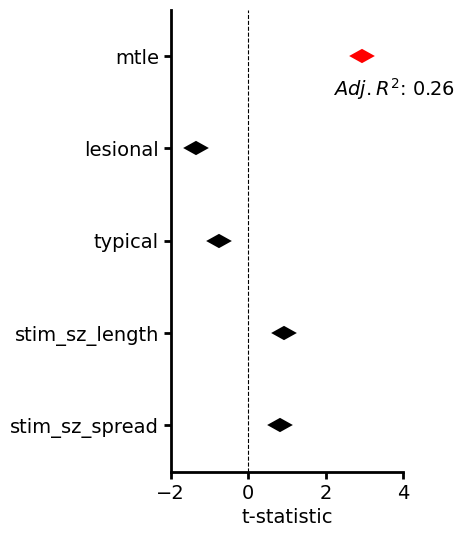

In [103]:
plot_linear_models(lm_df_left[lm_df_left.adult],['mtle','lesional','typical','stim_sz_length','stim_sz_spread'],subset='HUP')
plt.savefig(ospj(figpath,'mvlm_mtle_hup.pdf'),bbox_inches='tight')

#### Just CHOP

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     3.179
Date:                Mon, 12 May 2025   Prob (F-statistic):             0.0500
Time:                        09:46:50   Log-Likelihood:               0.085974
No. Observations:                  18   AIC:                             9.828
Df Residuals:                      13   BIC:                             14.28
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6512      0.333  

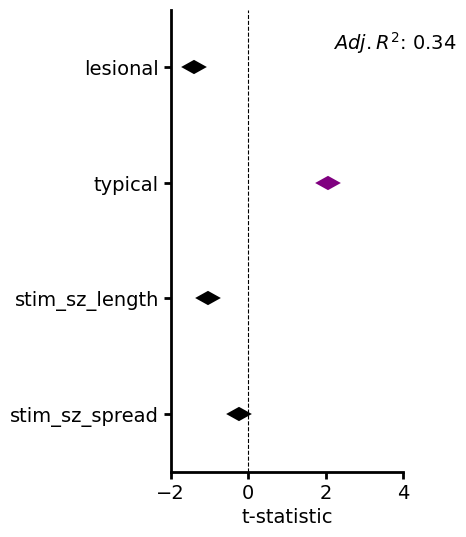

In [104]:
plot_linear_models(lm_df_left[~lm_df_left.adult],['lesional','typical','stim_sz_length','stim_sz_spread'],subset='CHOP')
plt.savefig(ospj(figpath,'mvlm_chop.pdf'),bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:                    MCC   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     3.125
Date:                Mon, 12 May 2025   Prob (F-statistic):             0.0491
Time:                        09:46:50   Log-Likelihood:                 1.4513
No. Observations:                  18   AIC:                             9.097
Df Residuals:                      12   BIC:                             14.44
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8126      0.341  

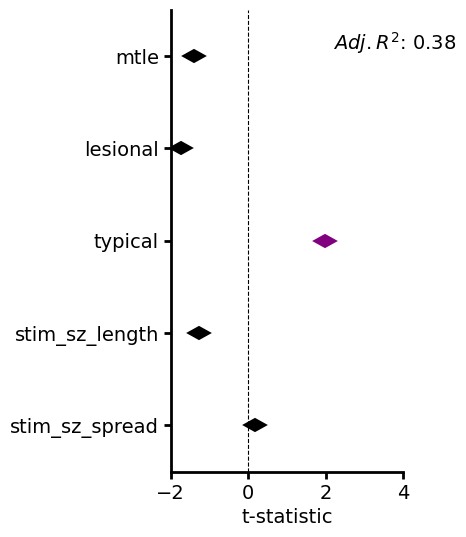

In [105]:
plot_linear_models(lm_df_left[~lm_df_left.adult],['mtle','lesional','typical','stim_sz_length','stim_sz_spread'],subset='CHOP')
plt.savefig(ospj(figpath,'mvlm_mtle_chop.pdf'),bbox_inches='tight')

### Machine Learning

In [106]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor  # or GradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Define features and target
X_cols = ['lesional', 'typical', 'age_at_onset', 'duration', 'age', 'stim_sz_length', 'stim_sz_spread']
# X_cols = ['typical','age_at_onset','adult']
y_col = 'MCC'
group_col = 'patient'
# Drop rows with NaNs in any of the X features
lm_df_filtered = lm_df_left.dropna(subset=X_cols)

# Extract X, y, and grouping variable
X = lm_df_filtered[X_cols].copy()
y = lm_df_filtered[y_col].values
groups = lm_df_filtered[group_col].values

# Optional: scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose model
model = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
# from sklearn.ensemble import GradientBoostingRegressor
# model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Leave-one-group (patient) out CV
logo = LeaveOneGroupOut()
preds, trues, test_patients = [], [], []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    model.fit(X_scaled[train_idx], y[train_idx])
    y_pred = model.predict(X_scaled[test_idx])
    
    preds.extend(y_pred)
    trues.extend(y[test_idx])
    test_patients.extend(groups[test_idx])

# Convert results to DataFrame
results_df = pd.DataFrame({
    'patient': test_patients,
    'true_MCC': trues,
    'pred_MCC': preds
})

# Evaluate
rmse = mean_squared_error(results_df['true_MCC'], results_df['pred_MCC'], squared=False)
r2 = r2_score(results_df['true_MCC'], results_df['pred_MCC'])

print(f"LOPO CV RMSE: {rmse:.3f}")
print(f"LOPO CV R²: {r2:.3f}")


LOPO CV RMSE: 0.415
LOPO CV R²: -0.210
